# **Feature Selection, Dimensionality Reduction and Clustering.**
Este notebook tiene como objetivo central construir un modelo de segmentación de clientes a partir del dataset previamente preprocesado. Continuando con el flujo de trabajo iniciado en el primer notebook, aquí se aplicarán técnicas estadísticas y de machine learning para:
- Seleccionar y transformar variables relevantes para el modelado
- Reducir la dimensionalidad de los datos de forma que se conserve la mayor cantidad posible de información
- Aplicar modelos de agrupamiento no supervisado (clustering)
- Evaluar y visualizar la calidad de las segmentaciones obtenidas

El output de este notebook será un conjunto de etiquetas de cluster asignadas a cada cliente, así como visualizaciones e interpretaciones preliminares, que alimentarán directamente el análisis en profundidad en el siguiente notebook.

## **Importación de librerías y configuración general.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con bases de datos, manipulación de datos y archivos. También se desactivan ciertos mensajes de advertencia que podrían ensuciar la salida.

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import numpy as np
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

## **Importación e información del Dataframe.**
En esta sección se importa el conjunto de datos ya codificado y limpio, generado en el notebook anterior. Se verifican su forma y características básicas para asegurar consistencia antes de aplicar modelos.

In [196]:
df = pd.read_csv('../data/processed/IA_Client_Segment_sample_v1.csv', index_col=0)
df.head()

Genero  Casado  Edad  Graduado  Experiencia_laboral  Gastoscore  \
ID                                                                          
CLI10          0       1    67         1                    2           0   
CLI100         1       1    64         1                    2           1   
CLI1000        1       1    65         1                    2           1   
CLI10000       1       0    33         0                    1           0   
CLI10001       1       1    52         0                    2           1   

          Family_Size  anno_nacimiento  Generacion  Ingresos_anuales_brutos  \
ID                                                                            
CLI10               3             1957           1                    93442   
CLI100              2             1960           1                    99774   
CLI1000             3             1959           1                    36756   
CLI10000            4             1991           2                    24616   
CLI10001            2             1972           1                    29834   

          Digital_encuesta  Gasto_medio_mensual_cuota  Abandono  Dias_cliente  \
ID                                                                              
CLI10                 1385                         80         1           195   
CLI100                1052                         50         1           360   
CLI1000               1717                         30         0           407   
CLI10000              1606                         30         0           544   
CLI10001              1346                         30         1           170   

          Profesion_Construcción  Profesion_Empresarial  \
ID                                                        
CLI10                          0                      0   
CLI100                         0                      0   
CLI1000                        0                      0   
CLI10000                       0                      0   
CLI10001                       0                      0   

          Profesion_Funcionario  Profesion_Otros  Profesion_Servicios  \
ID                                                                      
CLI10                         0                0                    0   
CLI100                        0                0                    0   
CLI1000                       0                0                    1   
CLI10000                      1                0                    0   
CLI10001                      0                1                    0   

          Profesion_Técnico  Zona_Centro  Zona_Levante  Zona_Noreste  \
ID                                                                     
CLI10                     1            0             0             0   
CLI100                    1            0             1             0   
CLI1000                   0            1             0             0   
CLI10000                  0            0             0             0   
CLI10001                  0            0             0             1   

          Zona_Noroeste  Zona_Norte  Zona_Periferia  Zona_Sur  Campaña__0  \
ID                                                                          
CLI10                 1           0               0         0           1   
CLI100                0           0               0         0           0   
CLI1000               0           0               0         0           0   
CLI10000              1           0               0         0           0   
CLI10001              0           0               0         0           1   

          Campaña__1  Campaña__3  Campaña__4  Campaña__5  
ID                                                        
CLI10              0           0           0           0  
CLI100             0           0           0           1  
CLI1000            0           1           0           0  
CLI10000           0           0           1           0  
CLI10001           0   

In [197]:
df.dtypes

Genero                       int64
Casado                       int64
Edad                         int64
Graduado                     int64
Experiencia_laboral          int64
Gastoscore                   int64
Family_Size                  int64
anno_nacimiento              int64
Generacion                   int64
Ingresos_anuales_brutos      int64
Digital_encuesta             int64
Gasto_medio_mensual_cuota    int64
Abandono                     int64
Dias_cliente                 int64
Profesion_Construcción       int64
Profesion_Empresarial        int64
Profesion_Funcionario        int64
Profesion_Otros              int64
Profesion_Servicios          int64
Profesion_Técnico            int64
Zona_Centro                  int64
Zona_Levante                 int64
Zona_Noreste                 int64
Zona_Noroeste                int64
Zona_Norte                   int64
Zona_Periferia               int64
Zona_Sur                     int64
Campaña__0                   int64
Campaña__1          

In [198]:
df.shape

(10065, 32)

In [199]:
df.columns

Index(['Genero', 'Casado', 'Edad', 'Graduado', 'Experiencia_laboral',
       'Gastoscore', 'Family_Size', 'anno_nacimiento', 'Generacion',
       'Ingresos_anuales_brutos', 'Digital_encuesta',
       'Gasto_medio_mensual_cuota', 'Abandono', 'Dias_cliente',
       'Profesion_Construcción', 'Profesion_Empresarial',
       'Profesion_Funcionario', 'Profesion_Otros', 'Profesion_Servicios',
       'Profesion_Técnico', 'Zona_Centro', 'Zona_Levante', 'Zona_Noreste',
       'Zona_Noroeste', 'Zona_Norte', 'Zona_Periferia', 'Zona_Sur',
       'Campaña__0', 'Campaña__1', 'Campaña__3', 'Campaña__4', 'Campaña__5'],
      dtype='object')

### **Matriz de correlación.**
Aunque en el análisis se realizó una matriz de correlación para identificar relaciones entre variables, **no se eliminaron aquellas con alta correlación, ya que el PCA aplicado posteriormente se encarga de condensar dicha información redundante en los componentes principales**. Por tanto, la colinealidad no afecta al clustering posterior, ya que el K-Means se aplica sobre los componentes ortogonales generados por el PCA.

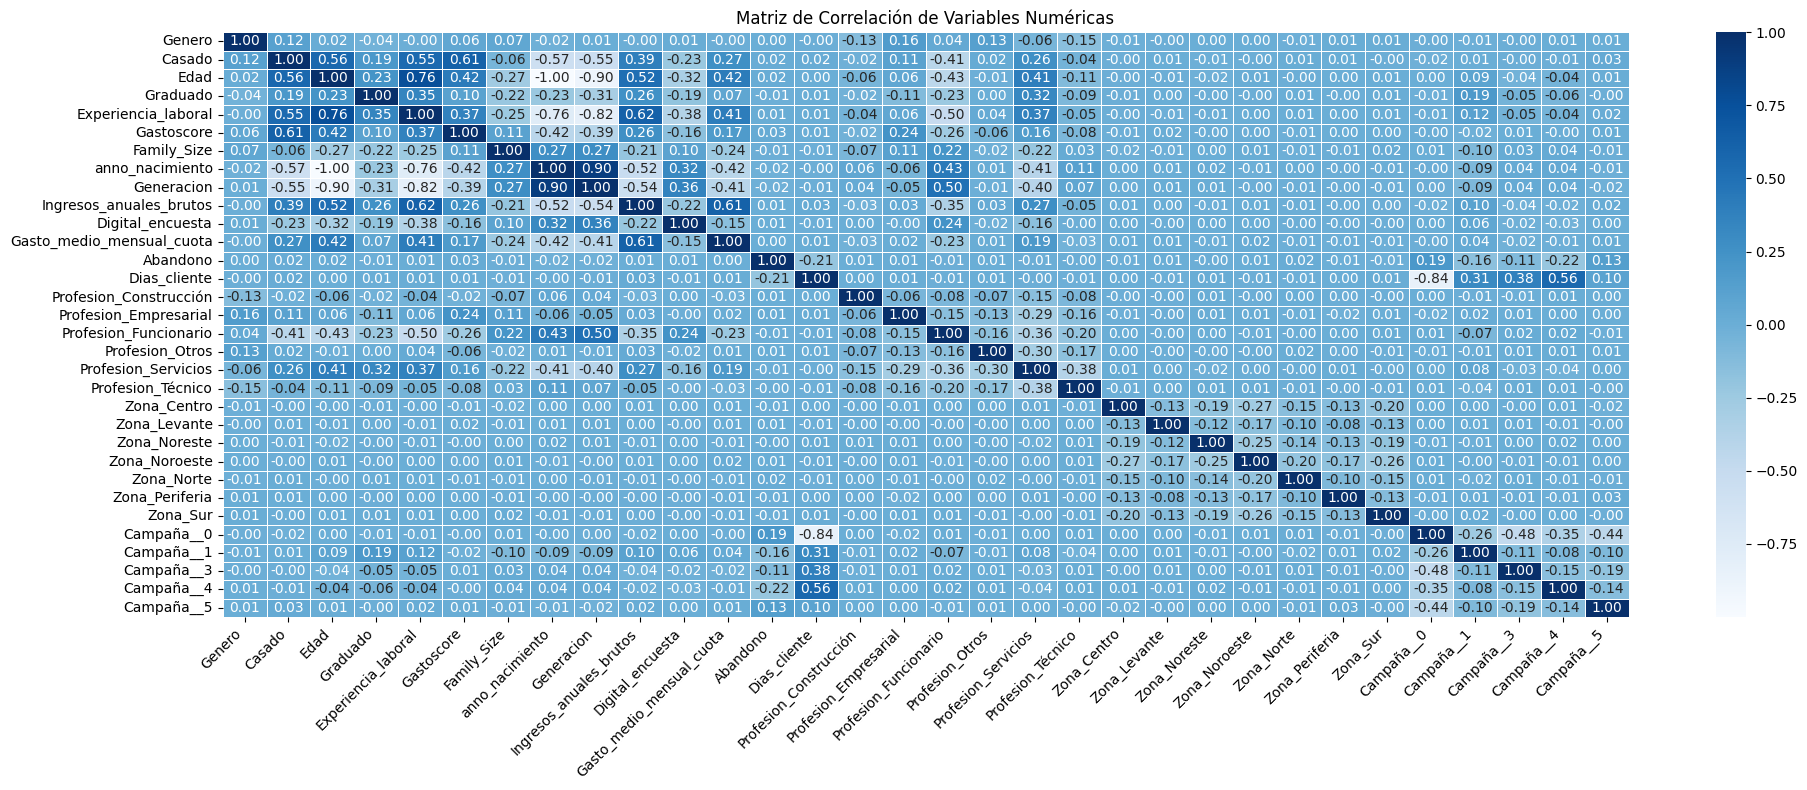

In [200]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), cmap='Blues', center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Boxplots de variables relevantes.**
Se han elaborado boxplots de las variables numéricas con el objetivo de analizar su distribución y detectar la presencia de posibles outliers. Este análisis previo permite identificar variables con alta dispersión o valores extremos que podrían influir en los resultados posteriores.

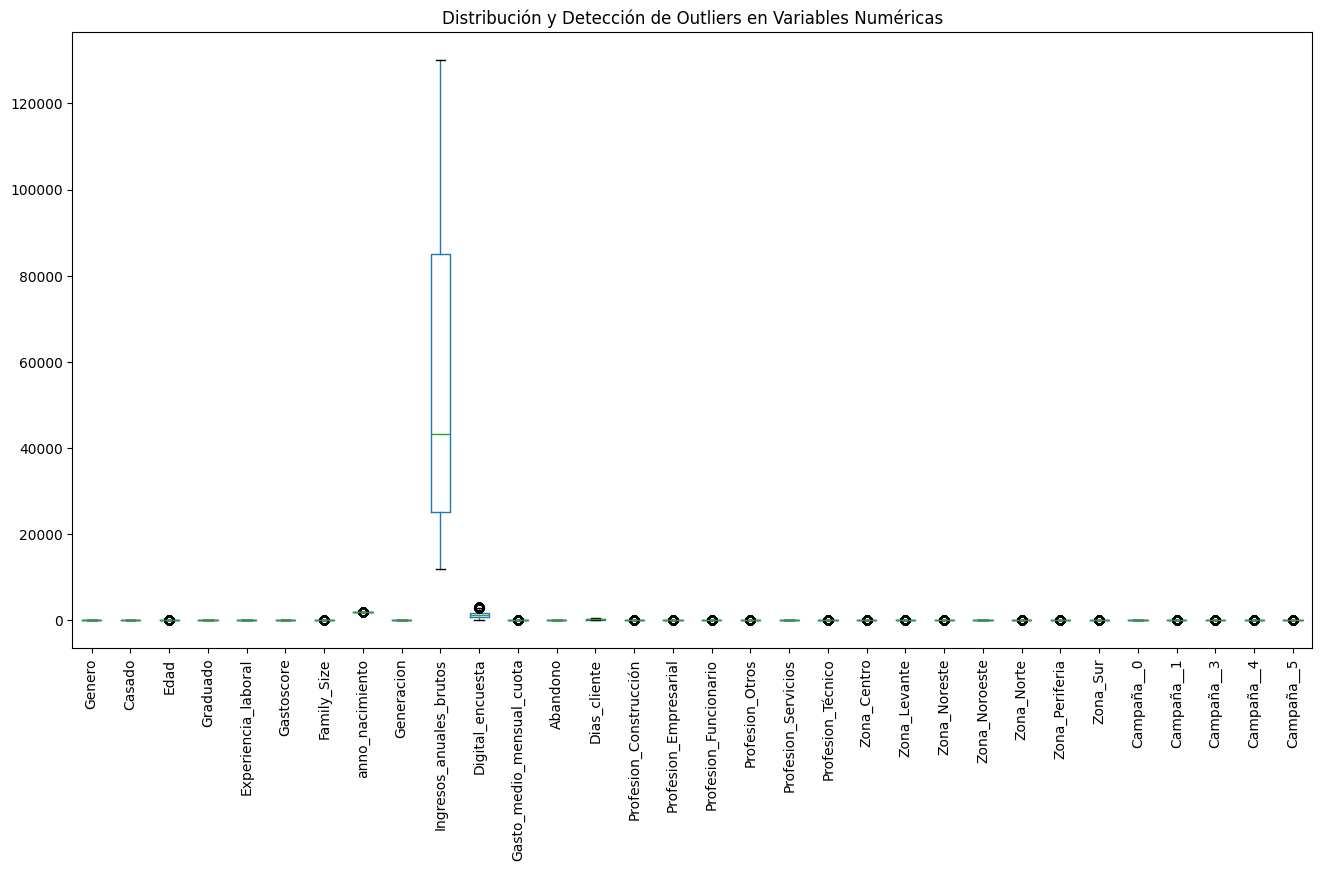

In [201]:
plt.figure(figsize=(16, 8))
df.boxplot(rot=90)
plt.title('Distribución y Detección de Outliers en Variables Numéricas')
plt.grid()
plt.show()

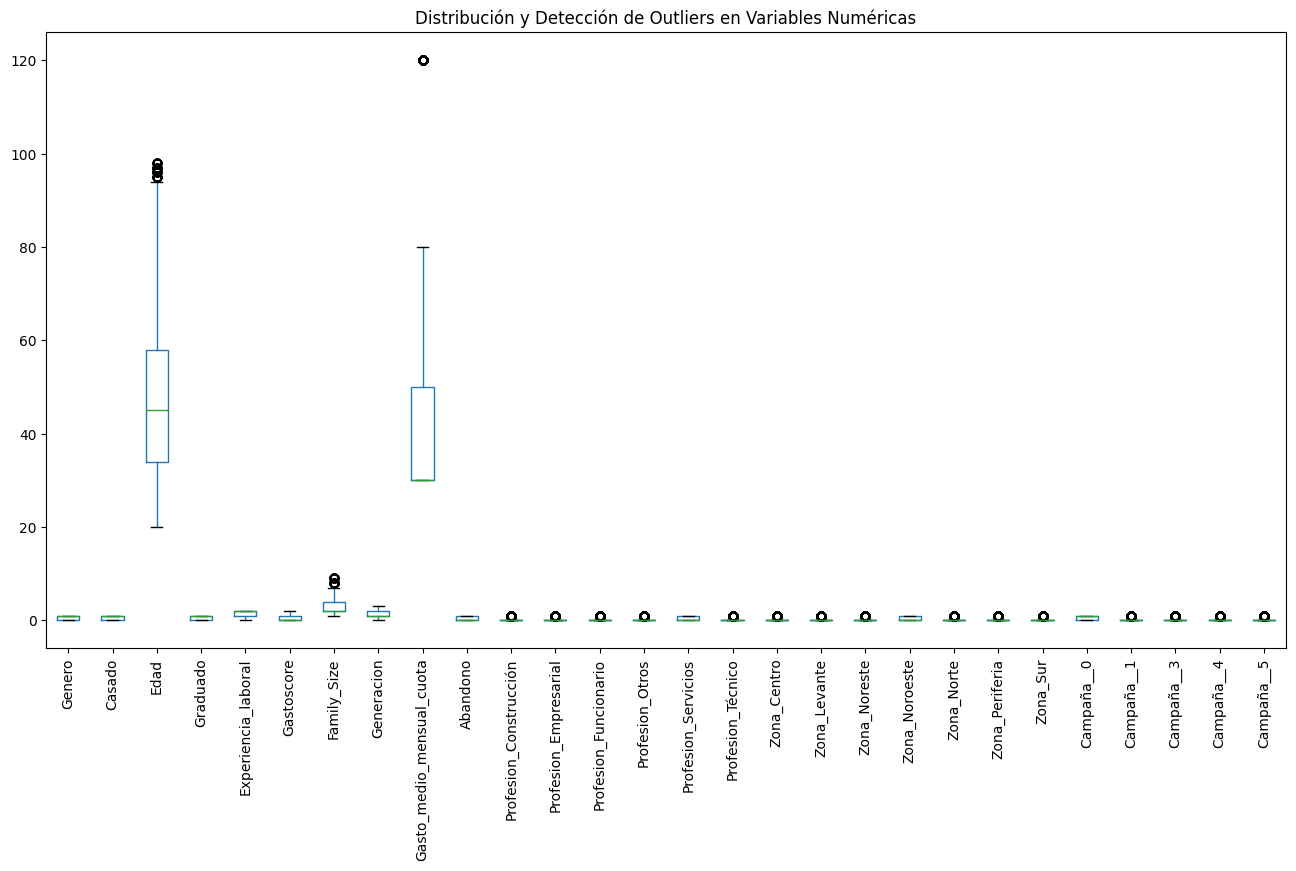

In [202]:
plt.figure(figsize=(16, 8))
df.drop(columns=['Ingresos_anuales_brutos', 'Digital_encuesta', 'anno_nacimiento', 'Dias_cliente']).boxplot(rot=90)
plt.title('Distribución y Detección de Outliers en Variables Numéricas')
plt.grid()
plt.show()

La visualización mediante boxplots ha evidenciado la **existencia de múltiples outliers** en las variables numéricas. No obstante, **estos valores no serán eliminados**, ya que el análisis principal se realizará mediante **PCA, técnica que absorbe parte de la variabilidad generada** por los outliers al condensar la información en los componentes principales. Además, para evitar que las diferencias de escala entre variables afecten al resultado, se aplicará un **proceso de estandarización previo** al análisis. Finalmente, se revisará el comportamiento de los outliers una vez realizados el PCA y el clustering, para evaluar si estos casos extremos influyen en la formación de los grupos

### **Gráficos de dispersión de un par de variables correlacionadas.**
Con el objetivo de complementar el análisis de la matriz de correlación, se han elaborado gráficos de dispersión entre aquellas variables numéricas que presentan una correlación elevada. Este análisis visual permite confirmar la existencia de relaciones lineales entre variables, identificar patrones claros de dependencia y detectar posibles redundancias de información. Además, facilita la interpretación de la estructura de los datos antes de aplicar técnicas de reducción de dimensionalidad como el PCA.

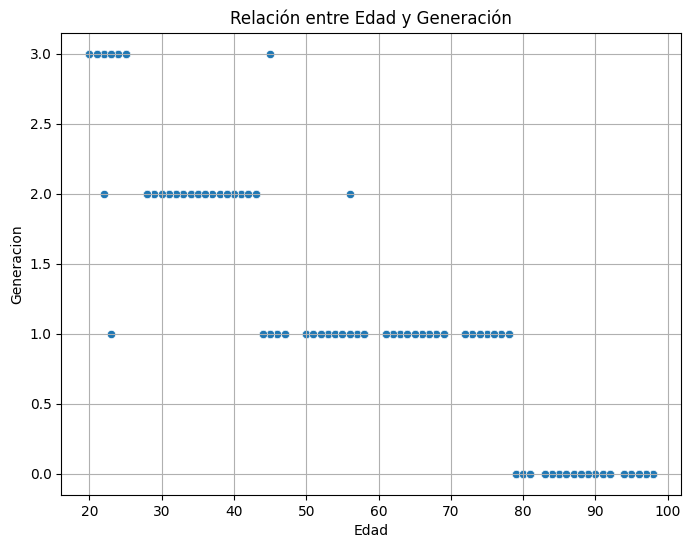

In [203]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Edad', y='Generacion')
plt.title('Relación entre Edad y Generación')
plt.grid()
plt.show()

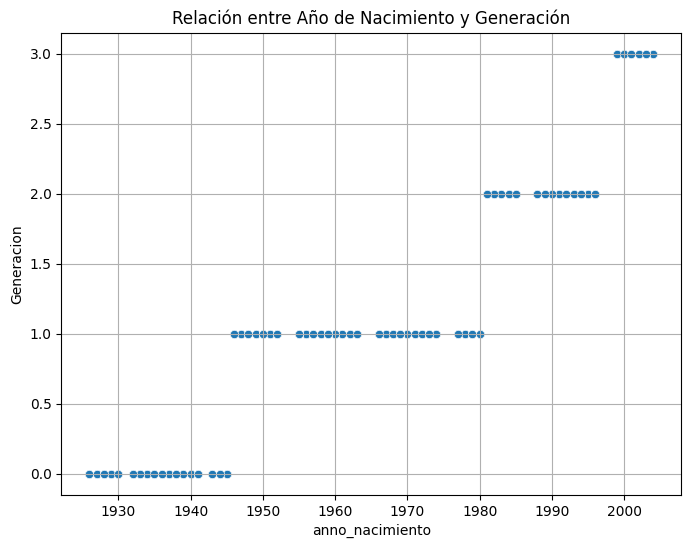

In [204]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='anno_nacimiento', y='Generacion')
plt.title('Relación entre Año de Nacimiento y Generación')
plt.grid()
plt.show()

Los gráficos de dispersión evidencian relaciones estructuradas y dependientes entre las variables **`Edad`**, **`Año de Nacimiento`** y **`Generación`**. Se observa una relación lineal inversa entre la edad y el año de nacimiento, totalmente coherente con la lógica demográfica. A su vez, la variable **`Generación`** muestra una correspondencia categórica perfectamente segmentada según el año de nacimiento, lo que confirma que está derivada directamente de dicha variable.

In [205]:
df.drop(columns=['anno_nacimiento'], inplace=True) # Alta correlación con Edad: Correlación perfecta.

## **Tratamiento de variables antes de aplicar PCA.**
Antes de aplicar técnicas de reducción de dimensionalidad como PCA, es fundamental preparar correctamente las variables. En esta etapa:
- Se detectan automáticamente qué variables numéricas son **continuas reales y categóricas ordinales** (a estandarizar) y cuáles son **binarias** (no se deben escalar).
- Se estandarizan las variables continuas mediante **StandardScaler**, ya que PCA es sensible a las diferencias de escala.
- Se prepara el subconjunto final de datos que será utilizado en la primera fase del PCA.

In [206]:
df_original = df.copy() # Guardar el DataFrame original para referencia.

In [207]:
# Selección de columnas numéricas.
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identificación de variables binarias, categóricas ordinales y continuas.
binary_cols = []
continuous_cols = [] # Variables continuas y categóricas ordinales a estandarizar.

for col in numerical_cols:
    unique_vals = df[col].dropna().unique()
    n_unique = len(unique_vals)
    
    if sorted(unique_vals) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

print("Variables binarias:", binary_cols)
print("Variables continuas a estandarizar:", continuous_cols)

Variables binarias: ['Genero', 'Casado', 'Graduado', 'Abandono', 'Profesion_Construcción', 'Profesion_Empresarial', 'Profesion_Funcionario', 'Profesion_Otros', 'Profesion_Servicios', 'Profesion_Técnico', 'Zona_Centro', 'Zona_Levante', 'Zona_Noreste', 'Zona_Noroeste', 'Zona_Norte', 'Zona_Periferia', 'Zona_Sur', 'Campaña__0', 'Campaña__1', 'Campaña__3', 'Campaña__4', 'Campaña__5']
Variables continuas a estandarizar: ['Edad', 'Experiencia_laboral', 'Gastoscore', 'Family_Size', 'Generacion', 'Ingresos_anuales_brutos', 'Digital_encuesta', 'Gasto_medio_mensual_cuota', 'Dias_cliente']


In [208]:
df[continuous_cols].nunique()

Edad                           69
Experiencia_laboral             3
Gastoscore                      3
Family_Size                     9
Generacion                      4
Ingresos_anuales_brutos      9277
Digital_encuesta              176
Gasto_medio_mensual_cuota       4
Dias_cliente                  571
dtype: int64

In [209]:
# Estandarización de las variables numéricas.
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df[continuous_cols])

# Reemplazo de las variables originales por las estandarizadas.
df[continuous_cols] = X_cont_scaled

In [210]:
# Validación de la estandarización.
pd.DataFrame(X_cont_scaled, columns=continuous_cols).describe().T[['mean', 'std']].T.round(4)

Edad  Experiencia_laboral  Gastoscore  Family_Size  Generacion  \
mean   0.0                  0.0         0.0         -0.0         0.0   
std    1.0                  1.0         1.0          1.0         1.0   

      Ingresos_anuales_brutos  Digital_encuesta  Gasto_medio_mensual_cuota  \
mean                      0.0              -0.0                        0.0   
std                       1.0               1.0                        1.0   

      Dias_cliente  
mean           0.0  
std            1.0

In [211]:
df.head()

Genero  Casado      Edad  Graduado  Experiencia_laboral  Gastoscore  \
ID                                                                              
CLI10          0       1  1.033109         1             0.774266   -0.725243   
CLI100         1       1  0.869618         1             0.774266    0.634588   
CLI1000        1       1  0.924115         1             0.774266    0.634588   
CLI10000       1       0 -0.819788         0            -0.486939   -0.725243   
CLI10001       1       1  0.215654         0             0.774266    0.634588   

          Family_Size  Generacion  Ingresos_anuales_brutos  Digital_encuesta  \
ID                                                                             
CLI10        0.170843   -0.629473                 1.095408          0.225548   
CLI100      -0.477793   -0.629473                 1.277962         -0.310242   
CLI1000      0.170843   -0.629473                -0.538872          0.759729   
CLI10000     0.819479    0.676307                -0.888873          0.581132   
CLI10001    -0.477793   -0.629473                -0.738436          0.162798   

          Gasto_medio_mensual_cuota  Abandono  Dias_cliente  \
ID                                                            
CLI10                      1.673825         1     -0.689941   
CLI100                     0.312961         1      0.419727   
CLI1000                   -0.594283         0      0.735814   
CLI10000                  -0.594283         0      1.657174   
CLI10001                  -0.594283         1     -0.858072   

          Profesion_Construcción  Profesion_Empresarial  \
ID                                                        
CLI10                          0                      0   
CLI100                         0                      0   
CLI1000                        0                      0   
CLI10000                       0                      0   
CLI10001                       0                      0   

          Profesion_Funcionario  Profesion_Otros  Profesion_Servicios  \
ID                                                                      
CLI10                         0                0                    0   
CLI100                        0                0                    0   
CLI1000                       0                0                    1   
CLI10000                      1                0                    0   
CLI10001                      0                1                    0   

          Profesion_Técnico  Zona_Centro  Zona_Levante  Zona_Noreste  \
ID                                                                     
CLI10                     1            0             0             0   
CLI100                    1            0             1             0   
CLI1000                   0            1             0             0   
CLI10000                  0            0             0             0   
CLI10001                  0            0             0             1   

          Zona_Noroeste  Zona_Norte  Zona_Periferia  Zona_Sur  Campaña__0  \
ID                                                                          
CLI10                 1           0               0         0           1   
CLI100                0           0               0         0           0   
CLI1000               0           0               0         0           0   
CLI10000              1           0               0         0           0   
CLI10001              0           0               0         0           1   

          Campaña__1  Campaña__3  Campaña__4  Campaña__5  
ID                                                        
CLI10              0           0           0           0  
CLI100             0           0           0           1  
CLI1000            0           1           0           0  
CLI10000           0           0           1           0  
CLI10001           0           0           0           0

## **Reducción de dimensionalidad mediante PCA.**
En esta sección se aplicará Análisis de Componentes Principales (PCA) como técnica de reducción de dimensionalidad, con el objetivo de:
- Sintetizar la información de múltiples variables numéricas en un espacio más reducido.
- Eliminar redundancia y colinealidad.
- Facilitar el análisis visual y la posterior aplicación de algoritmos de clustering.

Se compararán dos configuraciones distintas del modelo PCA:
1. Usando solo las variables continuas estandarizadas.
2. Usando variables continuas más variables categóricas transformadas mediante One-Hot Encoding.

### **PCA con variables continuas estandarizadas.**
Se aplica PCA exclusivamente sobre las variables numéricas continuas previamente escaladas. Este enfoque permite observar las relaciones puramente cuantitativas en el comportamiento del cliente y sirve como base comparativa frente a modelos más enriquecidos.

#### **Entrenamiento del modelo PCA: 2 Componentes.**
Se seleccionan los dos primeros autovectores (componentes principales) de la matriz de covarianza de los datos escalados, que mayor proporción de varinaza explican.

In [212]:
# Aplicación PCA.
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df[continuous_cols])
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Obtener todos los puntos del PCA.
pca_points = pca_df.values.tolist()

#### **Varianza explicada.**
Calculamos la proporción de varianza explicada por cada componente principal. Esto nos indica cuánta información (variabilidad) de los datos originales se conserva en cada componente.

In [213]:
# Varianza explicada.
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 43.36%
PC2: 12.77%
Varianza total explicada: 56.13%


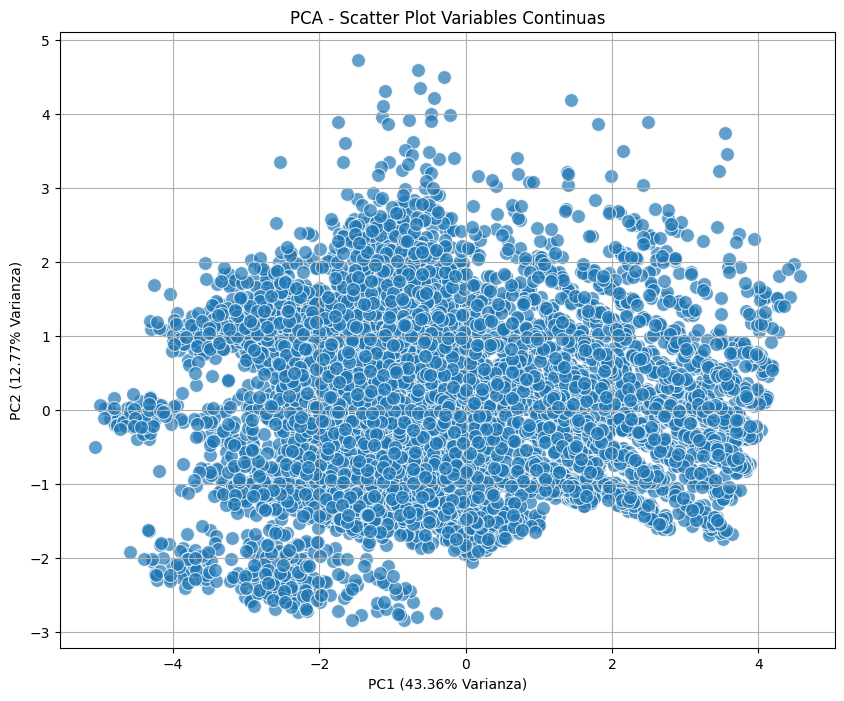

In [214]:
# Visualización: Scatter Plot.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA - Scatter Plot Variables Continuas')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

#### **Biplot de clientes y vectores de variables.**
Como parte del proceso de segmentación, se aplicó un análisis de componentes principales (PCA) con el fin de reducir la complejidad del conjunto de datos y facilitar su visualización.

El resultado se visualiza a través de un **biplot**, un gráfico que no solo muestra cómo se distribuyen los datos en las dos primeras dimensiones principales, sino que también ilustra de forma clara la **influencia que tiene cada variable original sobre estas dimensiones**. Esta herramienta resulta clave para interpretar el peso relativo de cada característica y su utilidad en la diferenciación de perfiles de clientes.

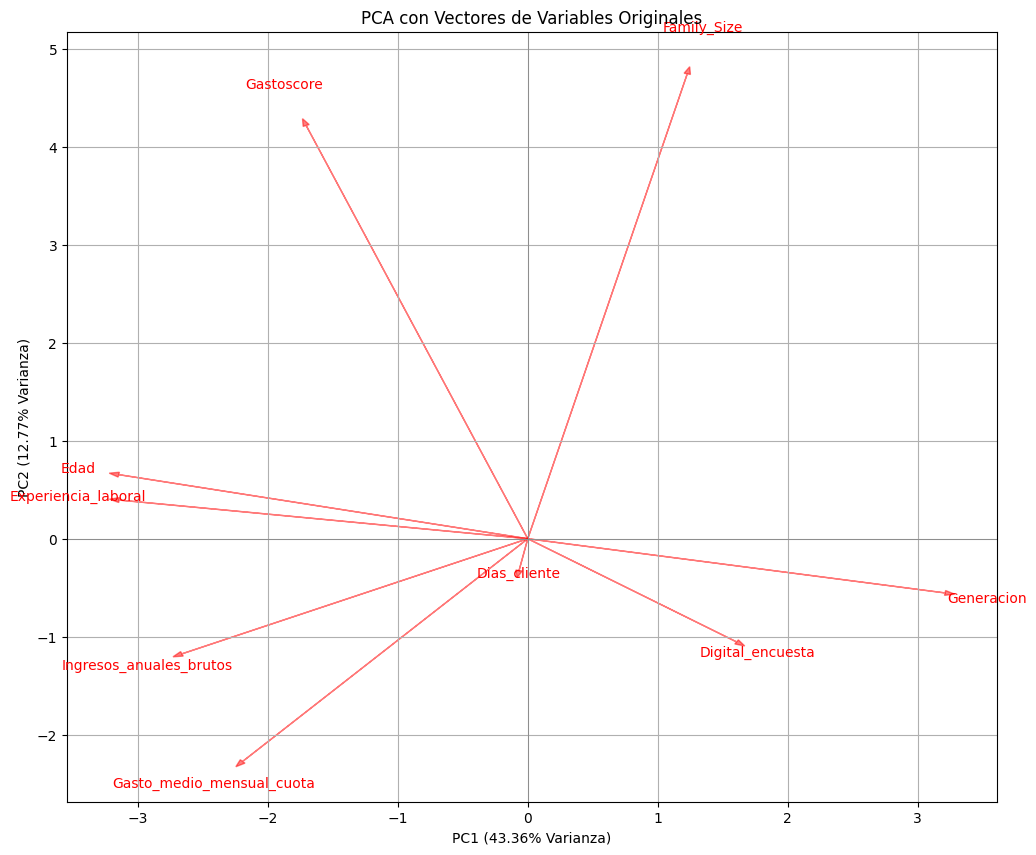

In [215]:
# Visualización: Biplot.
cargas = pca.components_.T
escalamiento = 7
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12,10))

for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

El análisis visual mediante el biplot nos permitió comprender cómo se relacionan las variables originales dentro de las dimensiones principales del modelo de segmentación. En este gráfico, observamos que cada variable aporta valor desde un ángulo distinto: **mientras algunas están asociadas con características socioeconómicas como la edad o los ingresos, otras reflejan el comportamiento digital o la antigüedad del cliente en la empresa.**

Lo más relevante es que las variables **no se solapan entre sí**, lo cual indica que **cada una está aportando información distinta y útil** al proceso de segmentación. Esto es clave, ya que permite construir **perfiles de clientes más completos** y diferenciados. Por ejemplo, la antigüedad del cliente destaca fuertemente en una de las dimensiones, lo cual podría estar vinculado a patrones de fidelidad, mientras que la edad y los ingresos parecen estar alineados, sugiriendo un perfil socioeconómico común.

**Contribución de las variables a los componentes principales.**

1. **`Edad`**: Contribuye de forma destacada al primer componente (PC1). Esto indica que la **edad** es una variable clave para diferenciar perfiles de clientes según su etapa de vida. Los clientes más jóvenes se posicionan en un extremo de este componente, mientras que los más mayores se sitúan en el otro extremo.

2. **`Experiencia laboral`**: Tiene una contribución similar a la de **edad**, lo que sugiere que la **experiencia laboral** está alineada con el primer componente, relacionado con el perfil socioeconómico. Los clientes con menos experiencia laboral se agrupan en el extremo opuesto al de aquellos con más experiencia.

3. **`Gasto Score`**: Aporta principalmente al segundo componente (PC2), lo que indica que el comportamiento de **gasto** de los clientes se asocia con **PC2**. Esto sugiere que los clientes con mayores gastos tienden a ser diferentes en términos de sus hábitos y patrones de consumo.

4. **`Family Size`**: Carga fuertemente en el segundo componente (PC2). Esto refleja que el **tamaño de la familia** es una variable importante para diferenciar a los clientes, con clientes con familias grandes posicionándose en el extremo positivo de este componente.

5. **`Generación`**: Tiene una carga positiva moderada en **PC1**, lo que indica que la **generación** del cliente es relevante para el análisis, separando a los clientes según su grupo generacional, afectando principalmente las características socioeconómicas.

6. **`Ingresos anuales brutos`**: Contribuye al primer componente (PC1), lo que sugiere que los **ingresos** están alineados con la **edad** y otros factores socioeconómicos, diferenciando principalmente a los clientes por su nivel de ingresos y estilo de vida.

7. **`Digital_encuesta`**: Tiene una carga pequeña en **PC1**, pero en dirección opuesta a las variables socioeconómicas. Esto refleja que los clientes **más digitales** se agrupan de manera diferente a aquellos con características tradicionales (edad e ingresos), diferenciándose por su nivel de interacción con plataformas digitales.

8. **`Gasto medio mensual cuota`**: Presenta una carga tanto en **PC1** como en **PC2**, lo que indica que el **comportamiento de gasto** es importante para la segmentación, afectando tanto las dimensiones socioeconómicas como las de consumo.

9. **`Días como cliente`**: Aunque tiene una carga pequeña en ambos componentes, se nota que tiene menos influencia en la segmentación. Esto sugiere que **la antigüedad del cliente** no tiene un impacto fuerte sobre la segmentación cuando se consideran otros factores como los ingresos y el tamaño de la familia.

#### **Análisis de cargas.**
Tras identificar visualmente la distribución de las variables mediante el biplot, es fundamental profundizar en el análisis de cargas para entender con precisión **cómo y cuánto contribuye cada variable a los componentes principales del modelo PCA**.

Este análisis numérico permite cuantificar la influencia de cada variable dentro de las nuevas dimensiones creadas por el PCA. Las **cargas** (o “loadings”) representan el **peso que tiene cada variable original en la construcción de un componente**, y son clave para interpretar el sentido de estos ejes.

In [216]:
# Definir las cargas antes de los gráficos.
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("Cargas de las variables en las componentes principales:")
cargas_df

Cargas de las variables en las componentes principales:


PC1       PC2
Edad                      -0.449613  0.093468
Experiencia_laboral       -0.449220  0.056382
Gastoscore                -0.243594  0.602789
Family_Size                0.175319  0.678166
Generacion                 0.458703 -0.079081
Ingresos_anuales_brutos   -0.380180 -0.167939
Digital_encuesta           0.229540 -0.150551
Gasto_medio_mensual_cuota -0.313446 -0.324886
Dias_cliente              -0.009582 -0.046336

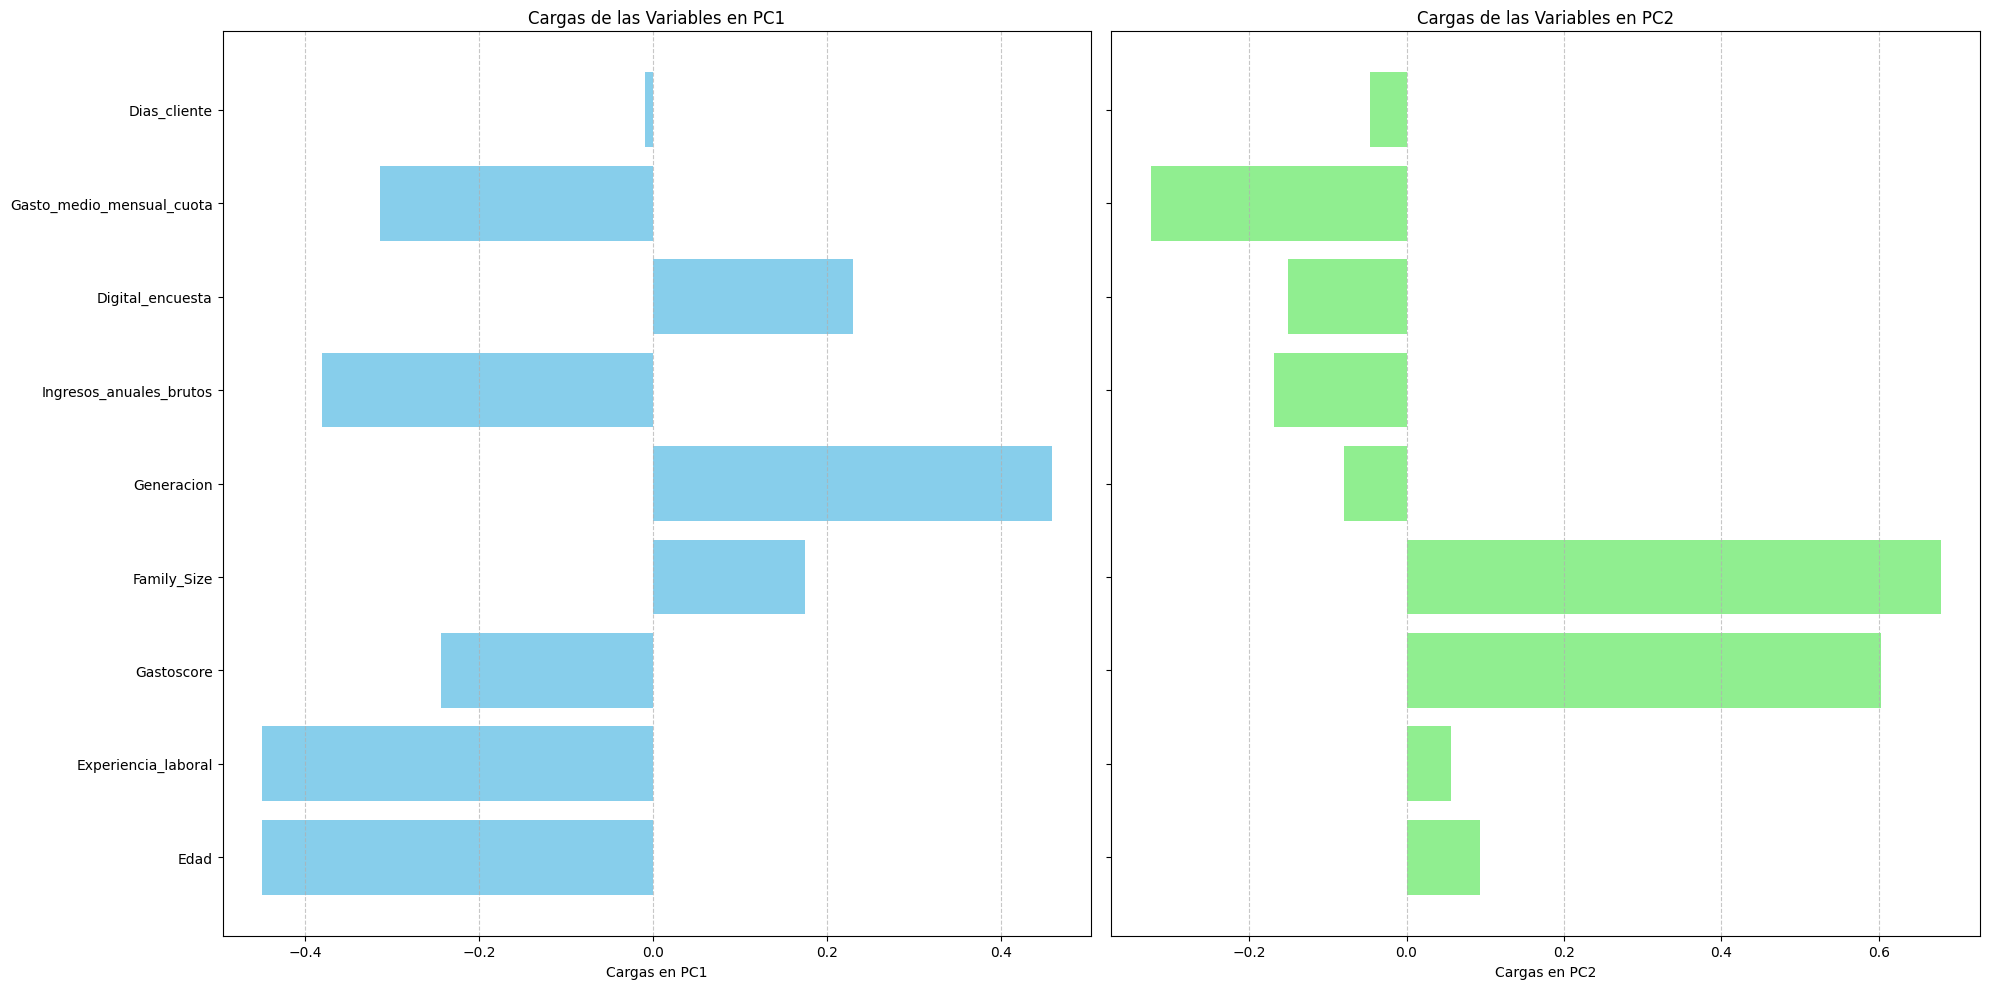

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

# Gráfico de Cargas para PC1
axes[0].barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
axes[0].set_xlabel('Cargas en PC1')
axes[0].set_title('Cargas de las Variables en PC1')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.7)

# Gráfico de Cargas para PC2
axes[1].barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
axes[1].set_xlabel('Cargas en PC2')
axes[1].set_title('Cargas de las Variables en PC2')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Los resultados muestran una distribución clara y lógica de las variables entre los dos primeros componentes principales:

- **`Edad`** y **`Experiencia laboral`** tienen cargas negativas moderadas en **PC1**, lo que indica que este componente está fuertemente relacionado con el perfil socioeconómico de los clientes. Esto sugiere que los factores como la **edad** y la **experiencia profesional** son determinantes clave para distinguir a los clientes en términos de sus etapas de vida y su historia laboral. **Clientes mayores y con más experiencia laboral** tienden a posicionarse en la parte superior de este eje, mientras que **clientes más jóvenes con menos experiencia laboral** se ubican en el extremo opuesto.
  
- **`Gasto Score`** tiene una carga alta en **PC2**, lo que refleja que el **comportamiento de gasto** está más relacionado con la segunda dimensión. Este componente parece estar separando a los clientes según sus **hábitos de consumo**: aquellos con un **mayor gasto mensual** tienen una alta carga en este componente, lo que indica que los patrones de gasto marcan una diferencia importante entre los grupos.

- **`Family Size`** tiene una carga significativa en **PC2**, sugiriendo que el **tamaño de la familia** también influye en este componente. La **estructura familiar** es un factor relevante, con los clientes de **familias más grandes** posicionándose en el extremo positivo de **PC2**, lo que podría estar vinculado a una mayor necesidad de productos o servicios familiares.

- **`Generación`** tiene una carga positiva moderada en **PC1**, lo que indica que la **generación del cliente** también juega un papel importante, diferenciando a los clientes más jóvenes de los más viejos. Los clientes más **jóvenes** tienden a posicionarse en el extremo positivo de **PC1**, mientras que los **clientes mayores** se ubican en el extremo opuesto.

- **`Ingresos anuales brutos`** tiene una carga negativa en **PC1**, lo que refuerza la idea de que las características socioeconómicas están dominadas por factores como la **edad** y el **nivel de ingresos**. Los clientes con **ingresos más bajos** tienden a ubicarse en el extremo negativo de **PC1**, mientras que aquellos con **ingresos más altos** se posicionan en el extremo positivo.

- **`Digital Encuesta`** tiene una carga moderada en **PC1**, lo que indica que el **comportamiento digital** de los clientes es un factor que influye en el primer componente. En este caso, los clientes más **digitalizados** tienden a tener una **interacción más alta con los medios digitales**, mientras que los **clientes menos digitales** se agrupan en el extremo opuesto.

- **`Gasto medio mensual cuota`** tiene una carga negativa en **PC1**, lo que indica que este comportamiento está relacionado con la **dimensión socioeconómica** de los clientes, similar a otras variables como **edad** e **ingresos**. Los **clientes con menores gastos mensuales** tienden a agruparse de manera opuesta a aquellos con mayores gastos.

- **`Días como cliente`** tiene cargas muy bajas en ambos componentes (PC1 y PC2), lo que indica que **la antigüedad del cliente** no tiene una gran influencia en los dos primeros componentes principales. Este hecho sugiere que **la fidelidad del cliente** no es un factor importante en las primeras dimensiones de segmentación, posiblemente debido a la influencia predominante de otros factores.

**Conclusión.** Las variables están bien distribuidas entre los componentes: **no hay redundancias** y cada una aporta una dimensión diferente y valiosa al modelo. El PCA captura dos ejes claramente diferenciados:

- **PC1**: Centrado en el perfil **socioeconómico** (edad, ingresos, experiencia laboral, gasto).
- **PC2**: Relacionado con el **comportamiento de consumo y la estructura familiar** (gasto, tamaño de la familia).

Esto sienta una base sólida para que los futuros **clusters** estén segmentados en función de estas diferencias relevantes en los clientes, permitiendo identificar perfiles claros que pueden ser utilizados para diseñar estrategias comerciales específicas.

In [218]:
# Variables con cargas bajas en PC1 y PC2. Se consideran redundantes, ya que no aportan información significativa a las componentes principales.
# La exclusión de estas variables puede simplificar el modelo y mejorar la interpretabilidad subiendo la varianza explicada.
redundantes = ['Dias_cliente']

#### **Determinación óptima del número de clusters: Elbow Method.**
Una vez reducido el conjunto de variables mediante el Análisis de Componentes Principales (PCA), el siguiente paso consiste en **determinar el número óptimo de clusters para la segmentación de clientes**. Para ello, se aplica el Método del Codo (Elbow Method), que permite identificar el punto en el que añadir más clusters no mejora significativamente la compactación de los grupos.

El criterio se basa en analizar la inercia intra-cluster (suma de distancias de cada punto al centroide de su cluster) y localizar el punto de inflexión o "codo" en la curva.

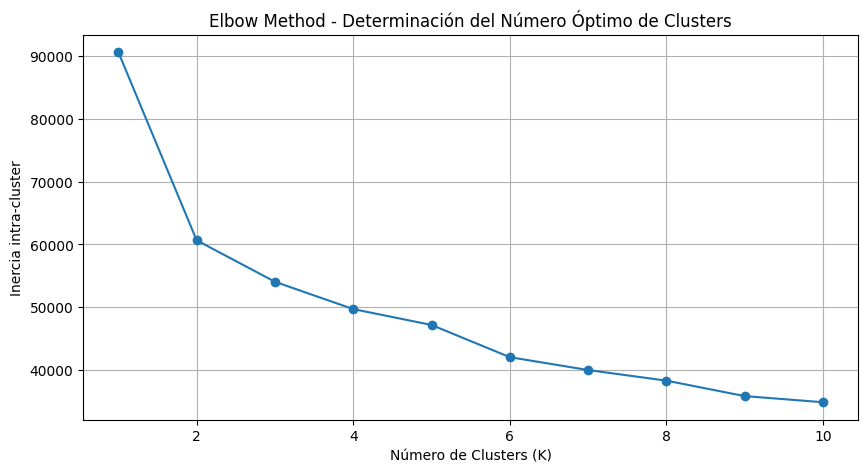

In [219]:
# Evaluación de la inercia para distintos valores de K.
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[continuous_cols])
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo.
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Determinación del Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia intra-cluster')
plt.grid()
plt.show()

In [220]:
clusters = 5 # Número óptimo de clusters determinado visualmente.
print(f"El número óptimo de clusters es: {clusters}")

El número óptimo de clusters es: 5


#### **Segmentación de clientes mediante K-Means.**
Una vez determinado el número óptimo de clusters mediante el Elbow Method, el siguiente paso consiste en aplicar el algoritmo K-Means para segmentar a los clientes en función de los componentes principales obtenidos con el PCA.

El objetivo de este proceso es **identificar grupos homogéneos de clientes que compartan características similares**, facilitando la elaboración de estrategias personalizadas de fidelización y maximización del valor del cliente.

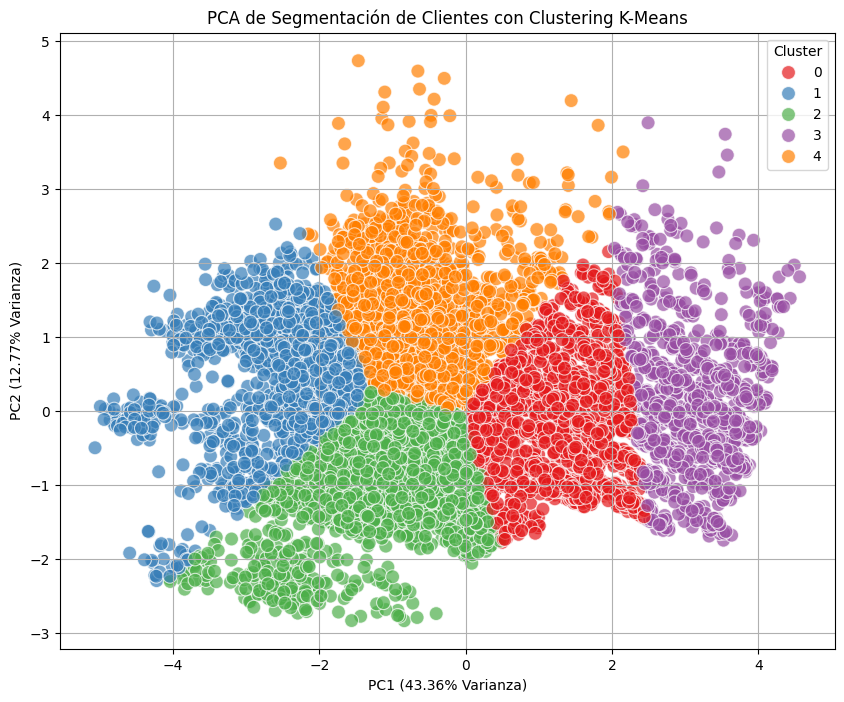

In [221]:
# Clustering con K-Means sobre PCA.
kmeans = KMeans(n_clusters=clusters, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame.
pca_df['Cluster'] = clusters

# Visualizar PCA con Clusters.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA de Segmentación de Clientes con Clustering K-Means')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

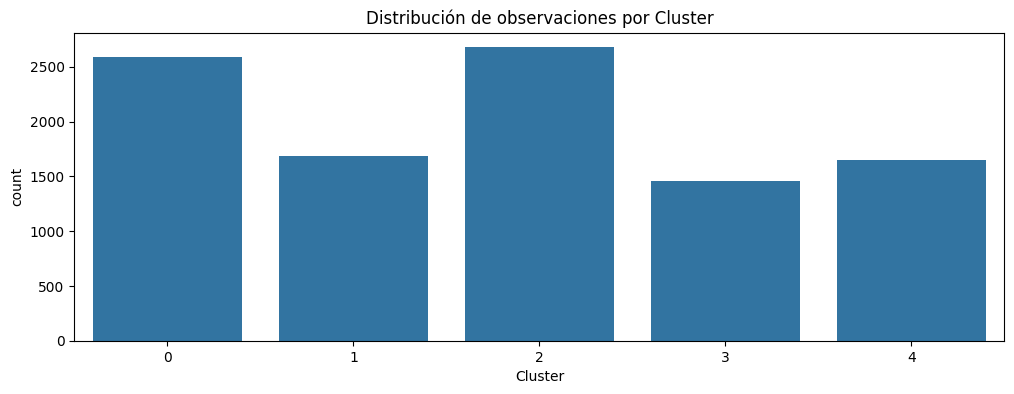

In [222]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Cluster', data=pca_df)
plt.title('Distribución de observaciones por Cluster')
plt.show()

Esta distribución homogénea es un indicador positivo, ya que evita la aparición de clusters residuales o poco representativos. Además, garantiza que cada grupo identificado tiene un volumen significativo de clientes, lo que facilita el análisis posterior y la implementación de estrategias de negocio diferenciadas para cada segmento.

### **PCA exploratorio: Variables continuas junto categóricas transformadas.**
Una vez comprendida la estructura subyacente del espacio de datos mediante el PCA aplicado únicamente sobre variables continuas estandarizadas, se amplía ahora el análisis incluyendo variables categóricas transformadas (One-Hot y Ordinal Encoding).

Esta configuración busca capturar relaciones cualitativas adicionales que podrían enriquecer el modelo, generar mayor separación entre observaciones y mejorar la interpretación posterior de los grupos de clientes.

Incorporar variables categóricas es particularmente relevante en este caso de uso, ya que aspectos como la profesión, la generación o la zona geográfica podrían tener un impacto significativo en el comportamiento de los clientes del sector telecomunicaciones.

El objetivo de este paso es:

- Evaluar si el nuevo espacio PCA mejora la **varianza explicada**.
- Comprobar si se logra una **mayor estructura o separación** entre perfiles de cliente.
- Comparar visualmente los resultados con el PCA anterior basado únicamente en continuas.

Esta exploración servirá como antesala al proceso de **clustering y segmentación**, y permitirá definir con mayor claridad el conjunto óptimo de variables a utilizar.

In [223]:
# Se recomienda no incluir variables con poca carga en PC1 y PC2. Detectadas en el PCA anterior.
df.drop(columns=redundantes, inplace=True)
for i in redundantes:
    continuous_cols.remove(i)
    print(f"Variable eliminada: {i}")

Variable eliminada: Dias_cliente


In [224]:
print(f"Variables continuas seleccionadas para PCA: {continuous_cols}")
print(f"Variables binarias detectadas: {binary_cols}")

Variables continuas seleccionadas para PCA: ['Edad', 'Experiencia_laboral', 'Gastoscore', 'Family_Size', 'Generacion', 'Ingresos_anuales_brutos', 'Digital_encuesta', 'Gasto_medio_mensual_cuota']
Variables binarias detectadas: ['Genero', 'Casado', 'Graduado', 'Abandono', 'Profesion_Construcción', 'Profesion_Empresarial', 'Profesion_Funcionario', 'Profesion_Otros', 'Profesion_Servicios', 'Profesion_Técnico', 'Zona_Centro', 'Zona_Levante', 'Zona_Noreste', 'Zona_Noroeste', 'Zona_Norte', 'Zona_Periferia', 'Zona_Sur', 'Campaña__0', 'Campaña__1', 'Campaña__3', 'Campaña__4', 'Campaña__5']


In [225]:
df.head()

Genero  Casado      Edad  Graduado  Experiencia_laboral  Gastoscore  \
ID                                                                              
CLI10          0       1  1.033109         1             0.774266   -0.725243   
CLI100         1       1  0.869618         1             0.774266    0.634588   
CLI1000        1       1  0.924115         1             0.774266    0.634588   
CLI10000       1       0 -0.819788         0            -0.486939   -0.725243   
CLI10001       1       1  0.215654         0             0.774266    0.634588   

          Family_Size  Generacion  Ingresos_anuales_brutos  Digital_encuesta  \
ID                                                                             
CLI10        0.170843   -0.629473                 1.095408          0.225548   
CLI100      -0.477793   -0.629473                 1.277962         -0.310242   
CLI1000      0.170843   -0.629473                -0.538872          0.759729   
CLI10000     0.819479    0.676307                -0.888873          0.581132   
CLI10001    -0.477793   -0.629473                -0.738436          0.162798   

          Gasto_medio_mensual_cuota  Abandono  Profesion_Construcción  \
ID                                                                      
CLI10                      1.673825         1                       0   
CLI100                     0.312961         1                       0   
CLI1000                   -0.594283         0                       0   
CLI10000                  -0.594283         0                       0   
CLI10001                  -0.594283         1                       0   

          Profesion_Empresarial  Profesion_Funcionario  Profesion_Otros  \
ID                                                                        
CLI10                         0                      0                0   
CLI100                        0                      0                0   
CLI1000                       0                      0                0   
CLI10000                      0                      1                0   
CLI10001                      0                      0                1   

          Profesion_Servicios  Profesion_Técnico  Zona_Centro  Zona_Levante  \
ID                                                                            
CLI10                       0                  1            0             0   
CLI100                      0                  1            0             1   
CLI1000                     1                  0            1             0   
CLI10000                    0                  0            0             0   
CLI10001                    0                  0            0             0   

          Zona_Noreste  Zona_Noroeste  Zona_Norte  Zona_Periferia  Zona_Sur  \
ID                                                                            
CLI10                0              1           0               0         0   
CLI100               0              0           0               0         0   
CLI1000              0              0           0               0         0   
CLI10000             0              1           0               0         0   
CLI10001             1              0           0               0         0   

          Campaña__0  Campaña__1  Campaña__3  Campaña__4  Campaña__5  
ID                                                                    
CLI10              1           0           0           0           0  
CLI100             0           0           0           0           1  
CLI1000            0           0           1           0           0  
CLI10000           0           0           0           1           0  
CLI10001           1           0           0           0           0

#### **Entrenamiento del modelo PCA: 2 Componentes.**
Se seleccionan los dos primeros autovectores (componentes principales) de la matriz de covarianza de los datos escalados, que mayor proporción de varinaza explican.

In [226]:
# Aplicación PCA.
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df)

# Crear DataFrame con los componentes principales.
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

#### **Varianza explicada.**
Calculamos la proporción de varianza explicada por cada componente principal. Esto nos indica cuánta información (variabilidad) de los datos originales se conserva en cada componente.

In [227]:
# Obtención de la varianza explicada.
varianza_explicada = pca.explained_variance_ratio_

# Mostrar varianza explicada.
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}% de la varianza explicada")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 36.73% de la varianza explicada
PC2: 10.61% de la varianza explicada
Varianza total explicada: 47.34%


Aunque la varianza total explicada es inferior al modelo anterior (centrado solo en variables continuas), este análisis permite **integrar más riqueza en la segmentación** al conservar otras dimensiones relevantes, como digitalización o generación.

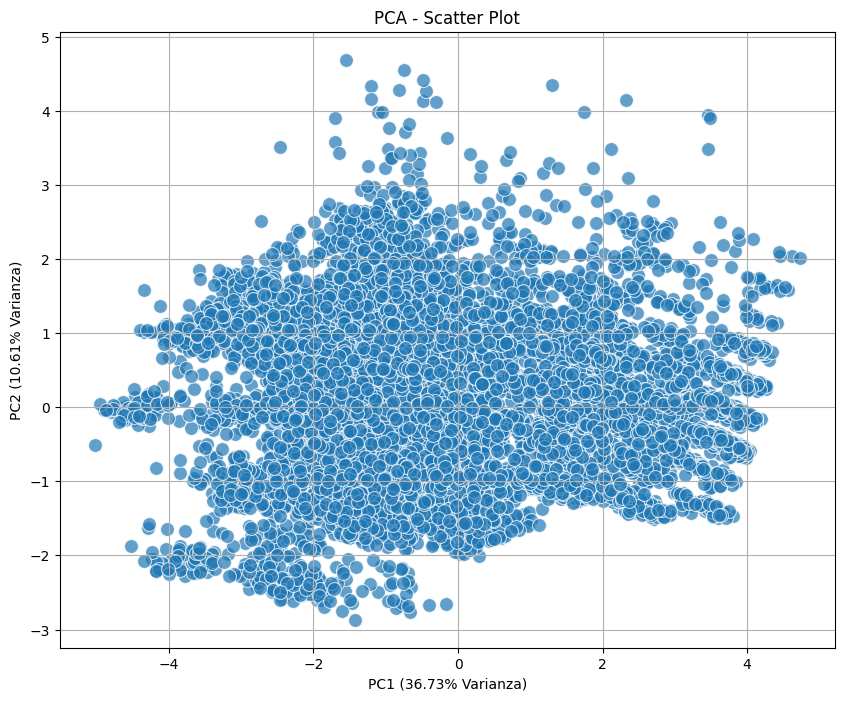

In [228]:
# Visualización: Scatter Plot.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA - Scatter Plot')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

#### **Biplot de clientes y vectores de variables.**
Como parte del proceso de segmentación, se aplicó un análisis de componentes principales (PCA) con el fin de reducir la complejidad del conjunto de datos y facilitar su visualización.

El resultado se visualiza a través de un **biplot**, un gráfico que no solo muestra cómo se distribuyen los datos en las dos primeras dimensiones principales, sino que también ilustra de forma clara la **influencia que tiene cada variable original sobre estas dimensiones**. Esta herramienta resulta clave para interpretar el peso relativo de cada característica y su utilidad en la diferenciación de perfiles de clientes.

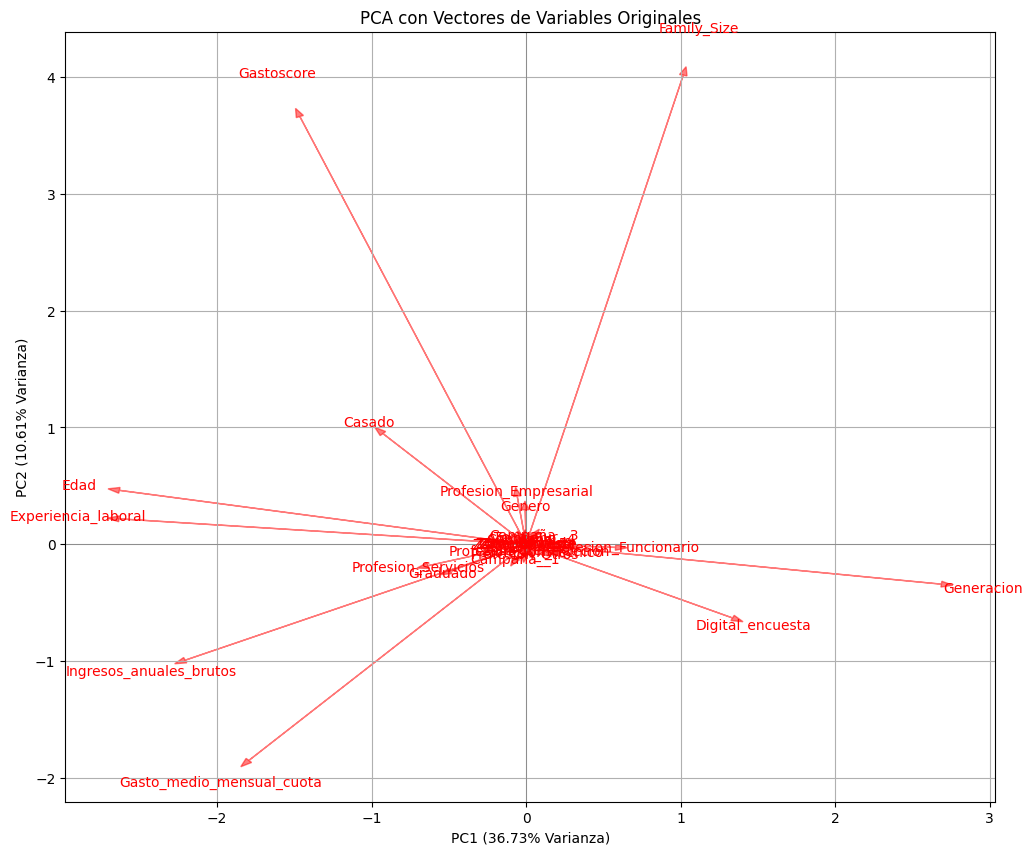

In [229]:
# Visualización: Biplot.
cargas = pca.components_.T
escalamiento = 6
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12, 10))
for i, var in enumerate(df.columns):
    plt.arrow(0, 0, cargas_scaled[i, 0], cargas_scaled[i, 1],
            color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i, 0]*1.1, cargas_scaled[i, 1]*1.1,
            var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

**Conclusiones Biplot : Vectores ampliados.** En la representación visual del biplot, se observa que ciertas variables destacan por la magnitud y dirección de sus vectores, lo que indica una mayor contribución a las componentes principales y, por ende, un papel relevante en la diferenciación de los perfiles de clientes. Estas variables son clave para la construcción de los clusters y permiten extraer patrones significativos. A continuación, se detallan las más influyentes:

1. **`Edad`**: Tiene una contribución notable al primer componente (PC1), situándose hacia el extremo negativo. Esto indica que la edad es una variable determinante en la segmentación, diferenciando especialmente a los clientes más jóvenes (valores negativos) de los más mayores (valores positivos), en el marco de un eje socioeconómico.

2. **`Experiencia laboral`**: Su vector está fuertemente alineado con el de **`Edad`**, lo que refuerza la idea de que ambas variables están altamente correlacionadas y forman parte del mismo eje interpretativo. Clientes con mayor experiencia tienden a situarse en el mismo segmento que los de mayor edad, reflejando trayectorias profesionales más largas y estables.

3. **`Ingresos anuales brutos`**: Presenta una carga importante en PC1, también en la dirección negativa. Su proximidad a **`Edad`** y **`Experiencia laboral`** confirma que esta variable contribuye a definir un perfil socioeconómico robusto: mayores ingresos están asociados a mayor edad y experiencia.

4. **`Gasto Score`**: Es la variable con mayor proyección sobre PC2, situándose claramente hacia el extremo superior. Esto sugiere que este componente capta con fuerza patrones de consumo diferenciados, especialmente en clientes con niveles de gasto alto, que se comportan de forma singular frente al resto del universo analizado.

5. **`Family Size`**: También contribuye significativamente a PC2. Su vector largo y vertical revela que el tamaño de la familia permite discriminar entre clientes con estructuras familiares más extensas (hacia la parte superior del eje) y aquellos con núcleos más reducidos.

6. **`Gasto medio mensual cuota`**: Tiene una carga moderada tanto en PC1 como en PC2, lo que indica que es una variable transversal. Aporta tanto al perfil financiero del cliente como a su comportamiento de consumo, y puede ser útil para detectar grupos con patrones de gasto más equilibrados o mixtos.

7. **`Generación`**: A pesar de ser una variable categórica transformada, se proyecta positivamente sobre PC1, en dirección opuesta a la edad. Esto indica que los clientes de generaciones más jóvenes se agrupan en un extremo distinto al de los clientes mayores, reforzando la segmentación generacional como dimensión clave. Tiene sentdio ya que esstamos diciendo que: Si una persona tiene un valor alto en **`Edad`**, seguramente pertenece a una generación más antigua (como los Baby Boomers); Si tiene un valor alto en **`Generación`** (es decir, pertenece a una generación joven, como Gen Z), entonces su **`Edad`**, será baja.

8. **`Digital Encuesta`**: Aunque con una proyección más moderada, se posiciona hacia el extremo positivo de PC1. Su dirección opuesta a la edad y los ingresos sugiere que los clientes con mayor afinidad digital tienden a ser más jóvenes, menos tradicionales y con un perfil de consumo diferenciado, posiblemente más alineado con canales digitales.

Sin embargo, al observar detenidamente la disposición de los vectores, se evidencia una notable **aglomeración de múltiples variables en el entorno del centroide del plano**. Esta acumulación dificulta la lectura y comprensión detallada de las direcciones, longitudes y contribuciones específicas de dichas variables, lo cual compromete la interpretación precisa de su influencia en la segmentación.

Por esta razón, **se procederá a realizar una ampliación específica de la zona central del biplot**. Esta medida permitirá analizar con mayor claridad el comportamiento relativo de las variables que presentan cargas más discretas, pero que, en conjunto, pueden ofrecer información significativa para una segmentación fina y estratégica.

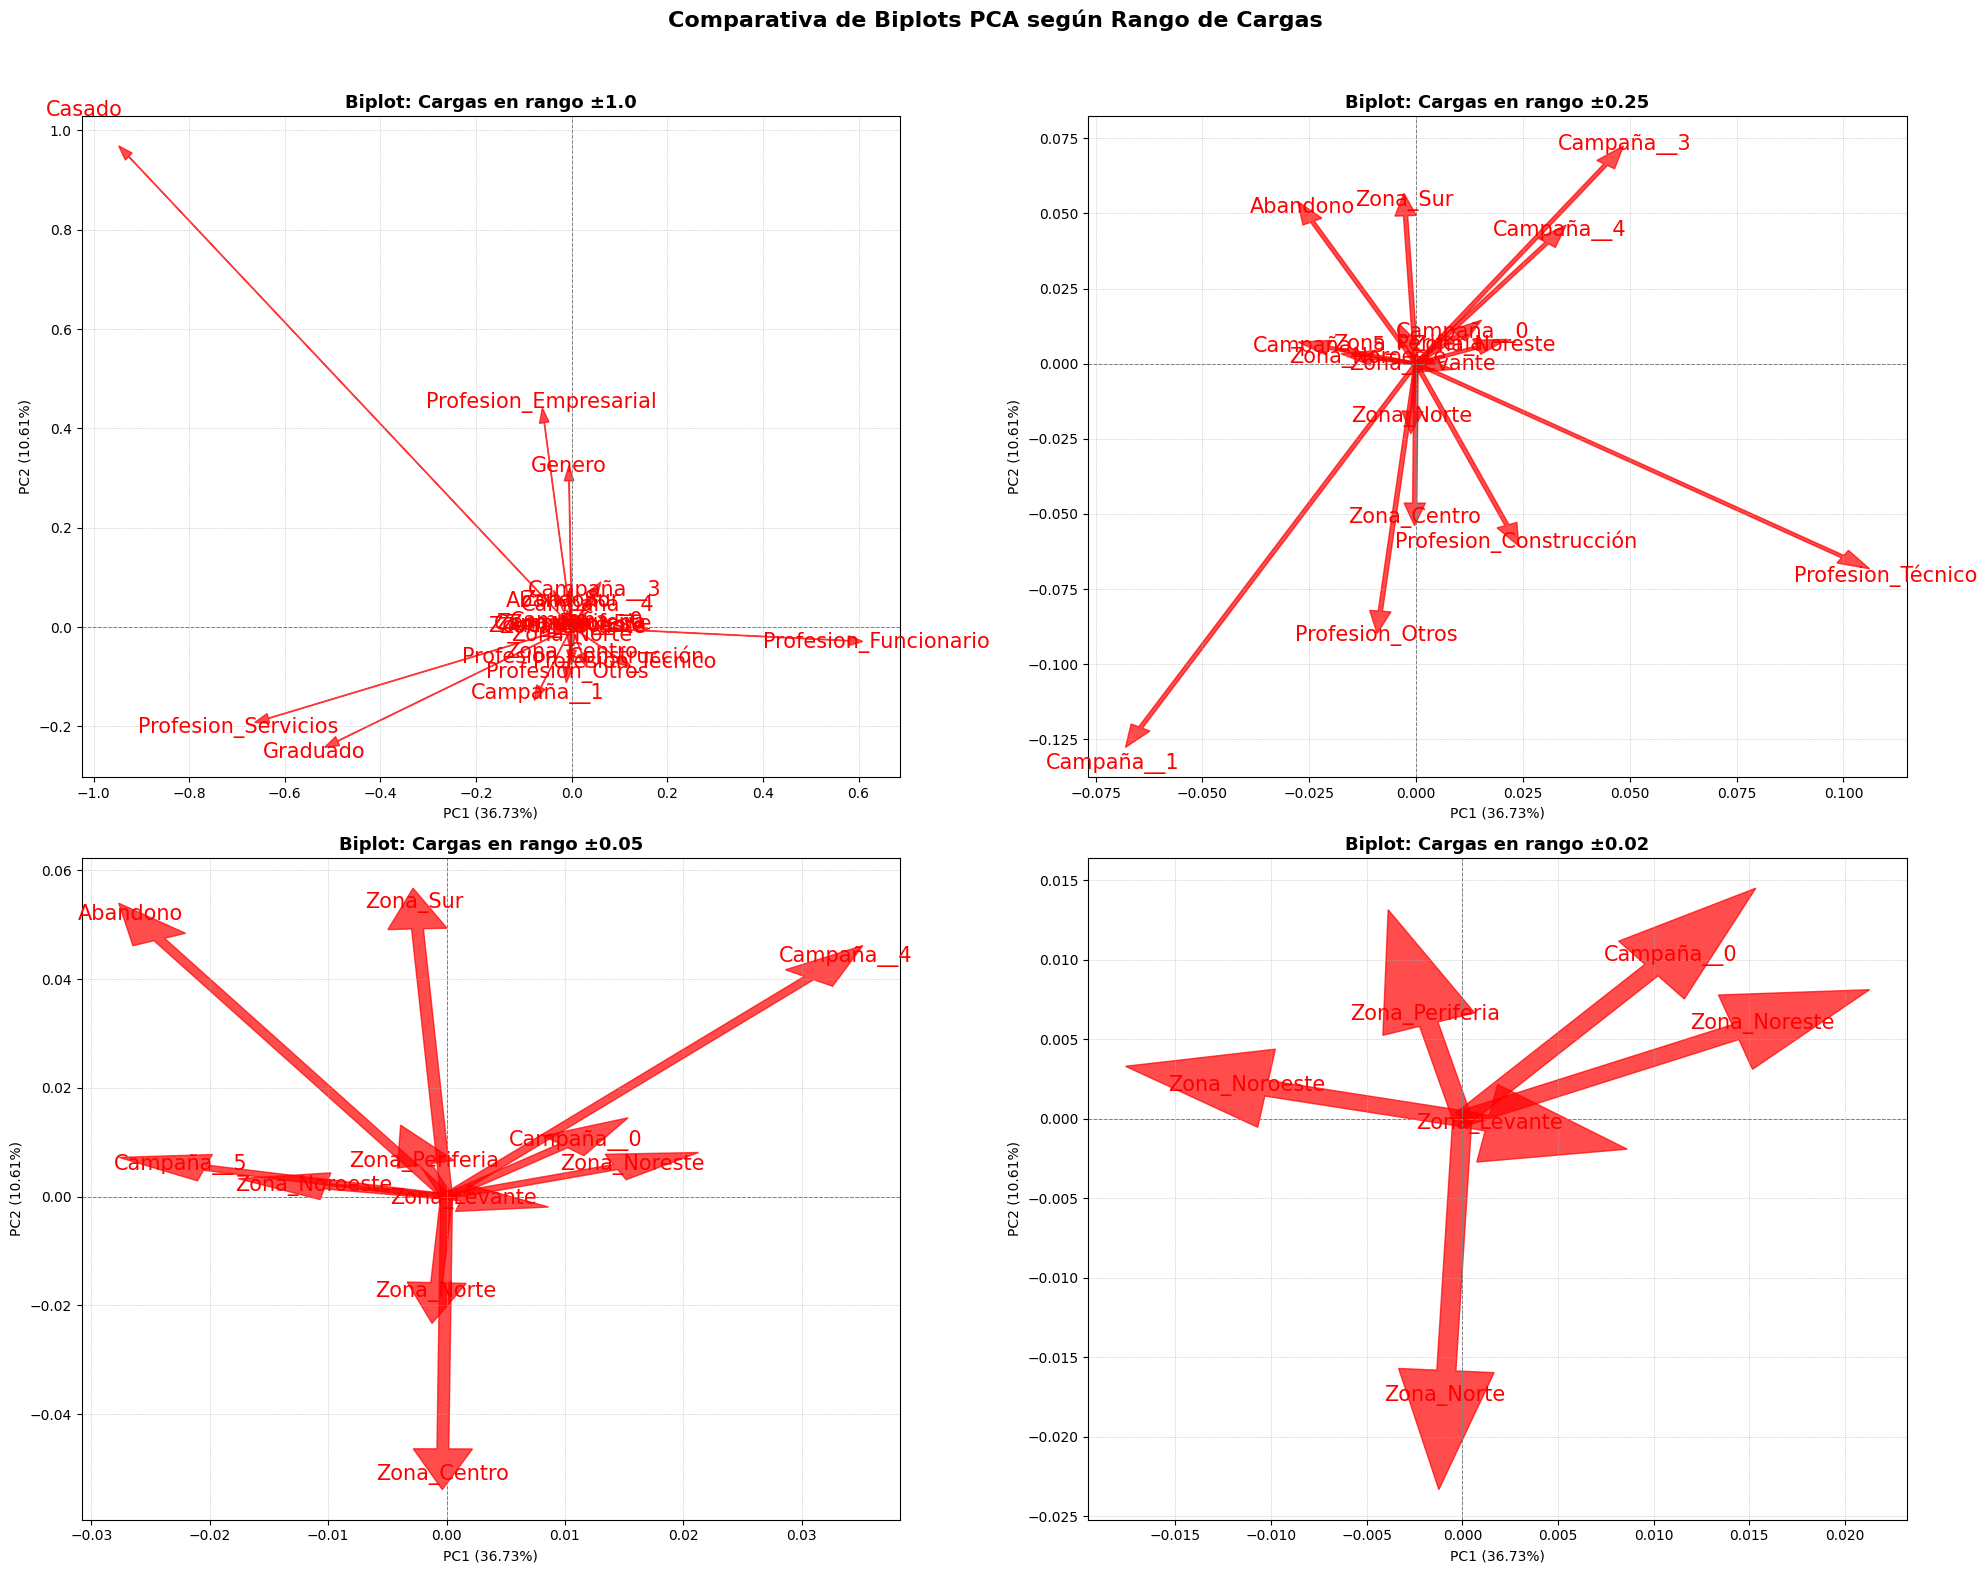

In [230]:
# Coordenadas de los vectores de carga escalados.
x_coords = cargas_scaled[:, 0]
y_coords = cargas_scaled[:, 1]
var_names = df.columns[:cargas.shape[0]]

# Rango para cada subgráfico.
rangos = [1.0, 0.25, 0.05, 0.02]

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()

for idx, r in enumerate(rangos):
    ax = axs[idx]

    # Máscara de filtrado por rango.
    mask = (np.abs(x_coords) <= r) & (np.abs(y_coords) <= r)
    indices = np.where(mask)[0]

    for i in indices:
        x, y = x_coords[i], y_coords[i]

        # Tamaño de la flecha.
        head_width = 0.005 if r <= 0.5 else 0.02
        ax.arrow(0, 0, x, y, alpha=0.7, head_width=head_width, color='r')
        ax.text(x * 1.1, y * 1.1, var_names[i], fontsize=15, ha='center', va='center', color='r')

    ax.set_title(f'Biplot: Cargas en rango ±{r}', fontsize=13, fontweight='bold')
    ax.set_xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}%)')
    ax.set_ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}%)')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.grid(True, linestyle=':', linewidth=0.5)

plt.suptitle('Comparativa de Biplots PCA según Rango de Cargas', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

**Análisis de variables (Rango ±1.0).**
1. **`Casado`**: Esta variable presenta la **mayor carga positiva sobre PC2**. Su vector es largo y muy vertical, lo que sugiere que **el estado civil** es una de las variables más influyentes en la dimensión PC2. Esto implica que estar casado o no representa una distinción clara entre tipos de clientes, posiblemente asociada a diferencias en responsabilidades familiares, decisiones financieras o nivel de estabilidad personal.

2. **`Profesion: Empresarial`**: Muestra una **carga positiva moderada** en ambos componentes (PC1 y PC2), lo que indica que los clientes del sector empresarial o ejecutivo están relacionados con **perfiles económicamente estables, activos y posiblemente digitalizados**. Esta combinación les posiciona como un grupo relevante tanto en cuanto a ingresos como a comportamiento de consumo o adopción de servicios.

3. **`Género`**: Su vector se orienta en dirección muy similar al de **`Profesion: Empresarial`**, lo que sugiere cierta **correlación entre ambos factores**. Esto podría reflejar, por ejemplo, una mayor presencia de cierto género en profesiones empresariales o diferencias de comportamiento vinculadas al sexo del cliente dentro del ámbito laboral y económico.

4. **`Profesion: Funcionario`**: Se sitúa claramente en el eje positivo de PC1, con una orientación levemente hacia PC2. Este patrón sugiere que los **empleados públicos** tienden a agruparse con perfiles estables, con comportamiento financiero y laboral predecible. Su posición destaca por su diferenciación frente a otros grupos ocupacionales, lo que refuerza su peso como segmento específico.

5. **`Profesion: Servicios`**: Carga negativamente en ambos componentes, destacándose en el cuadrante inferior izquierdo. Este comportamiento indica que quienes trabajan en el sector servicios o artístico se alejan del perfil tradicional o estructurado. Pueden representar un segmento más informal, con menores ingresos o comportamientos más dispersos.

6. **`Graduado`**: Aunque su carga es más discreta, se ubica junto a **`Profesion: Servicios`**, en el cuadrante negativo. Esto sugiere que **el nivel educativo universitario** no necesariamente se alinea con profesiones altamente estructuradas o ingresos elevados, sino que puede estar más vinculado a perfiles alternativos, especialmente dentro del sector servicios o artístico. Estar graduado no siempre significa que trabajas en una gran empresa. En este caso, muchos graduados parecen estar trabajando en ámbitos menos estructurados o más creativos, como el arte, atención al cliente, hostelería, etc.

**Análisis de variables (Rango ±0.25 y ±0.05).**

1. **`Campaña 1`**: Esta variable presenta una **carga negativa moderada en PC1 y PC2**, proyectándose en el cuadrante inferior izquierdo. Esto indica que los clientes que participaron en esta campaña tienden a agruparse en segmentos diferenciados con respecto a los perfiles socioeconómicos y de comportamiento general. Es posible que esta campaña haya estado dirigida a un público específico, con menor nivel de digitalización, ingresos o antigüedad.

2. **`Abandono`**: Tiene una **ligera proyección positiva en PC2**, situándose cerca del eje vertical superior. Esto sugiere que el abandono está más asociado a **características de comportamiento** que a factores estrictamente económicos o sociodemográficos. En otras palabras, los clientes que han abandonado podrían hacerlo por motivos relacionados con experiencia, atención o adecuación del servicio, más que por edad o ingresos.

3. **`Campaña 3` y `Campaña 4`**: Ambas se proyectan con **cargas positivas leves sobre PC2**, aunque desde posiciones ligeramente diferentes. Esto sugiere que estas campañas estuvieron más orientadas a **clientes activos o con perfiles de consumo más específicos**, diferenciándolos de aquellos alcanzados por campañas como la **`Campaña_1`**. Podrían reflejar acciones más segmentadas y efectivas.

4. **`Profesion: Técnico`**: Se distingue claramente por su **carga positiva en PC1**, lo cual indica que este grupo profesional está vinculado a un perfil más estructurado, posiblemente con mayor nivel educativo, estabilidad laboral y poder adquisitivo. Este vector refuerza la idea de que los técnicos (médicos, ingenieros, etc.) forman un grupo con características claras y homogéneas.

5. **`Profesion: Construcción`**: Tiene una **proyección positiva muy leve sobre PC1**, cercana al eje horizontal. Su peso es bajo pero diferenciador, lo que indica que este grupo ocupa un punto intermedio entre perfiles más formales y los más informales. Puede tener niveles de ingreso variados, pero sin características muy marcadas en consumo o digitalización.

6. **`Profesion: Otros`**: Se sitúa cerca del origen, aunque con una **carga leve negativa en PC1**, lo que sugiere que este grupo es más heterogéneo o representa un perfil **menos definido o más marginal dentro de la segmentación**. Su dispersión puede reflejar clientes con ocupaciones diversas, con poca capacidad predictiva para el modelo.


7. **`Campaña 5`**: Esta campaña se proyecta con **una carga negativa ligera en PC1 y mínima en PC2**, situándose en el cuadrante inferior izquierdo del plano. Su localización indica que **los clientes que participaron en esta campaña tienen características sutilmente diferentes al perfil promedio**, tal vez con un nivel de ingresos menor o menor interacción digital. Es posible que esta campaña se haya orientado a recuperar clientes menos activos o con menor potencial de conversión inmediata.

3. **`Campaña 0`**: Tiene una **posición centrada y ligeramente positiva en PC1**, pero con muy baja carga en PC2, lo cual la posiciona muy cerca del origen del plano. Esta ubicación sugiere que **Campaña 0 no está fuertemente asociada a ninguna dimensión principal del modelo**, y por tanto podría haber sido una campaña **más generalista**, sin una orientación clara hacia un segmento específico. Es posible que se tratara de una campaña masiva o inicial, cuyo objetivo no fue la personalización sino la cobertura amplia.

**Análisis de variables (Rango ±0.02).**
1. **`Zona: Centro`**: Esta zona muestra una **carga claramente negativa sobre PC2**, lo que la sitúa de forma destacada en la parte inferior del gráfico. Su posición sugiere que los clientes residentes en **Castilla-La Mancha, Madrid y Extremadura** presentan comportamientos diferenciados respecto al resto del país, especialmente en relación con variables vinculadas al eje PC2, como campañas o abandono. Al ser zonas con ciudades grandes, puede que tengan más acceso a todo, o bien que estén saturados de información. También puede ser que haya más competencia, y por eso reaccionen distinto a campañas o abandonos.

2. **`Zona: Norte`**: Esta zona muestra una **carga negativa clara en PC2**, siendo la más destacada en ese eje. Su posición sugiere que los clientes de esta zona (País Vasco, Cantabria, Navarra, La Rioja) **tienen un comportamiento diferenciado**, posiblemente menos reactivo a campañas o con mayor estabilidad (menos abandono o menor dinamismo). Su perfil parece más conservador o tradicional dentro del modelo.

3. **`Zona: Periferia`**: Situada en el cuadrante superior izquierdo, con **carga positiva moderada en PC2 y leve negativa en PC1**. Esto indica que los clientes de las Islas Canarias, Ceuta y Melilla pueden presentar comportamientos menos alineados con el consumo central, tal vez por características geográficas, acceso limitado o hábitos distintos. Podrían requerir estrategias diferenciadas.

4. **`Zona: Levante`**: Se encuentra muy cerca del centro del gráfico, con **cargas casi neutras**, lo que sugiere que **no destaca por un comportamiento particular** dentro del modelo. Sus clientes tienen un perfil medio, equilibrado, y no condicionan significativamente los ejes principales del análisis.

5. **`Zona: Noreste`**: Se sitúa en el cuadrante izquierdo, con **carga negativa leve en PC1** y casi neutra en PC2. Esta zona (Galicia, Asturias, Castilla y León) parece reflejar un perfil algo más distante del comportamiento económico central, quizás con menor digitalización o envejecimiento poblacional.

6. **`Zona: Noreste`**: Tiene **una carga positiva ligera sobre PC1 y sobre PC2**, situándose en el cuadrante superior derecho. Este posicionamiento sugiere un perfil más alineado con dinámicas activas: mayor respuesta a campañas, comportamiento digital o nivel adquisitivo algo superior. Puede representar un segmento interesante para estrategias comerciales. Este sector se conforma por: Cataluña, Aragon y Baleares.


**Tabla resumen de análisis PCA.**

| Variable                        | Rango de carga | Posición en el gráfico        | Interpretación resumida                                                                                   |
|--------------------------------|----------------|-------------------------------|------------------------------------------------------------------------------------------------------------|
| **Casado**                     | ±1.0           | PC2+, vertical                 | Variable muy influyente. Estar casado diferencia claramente a los clientes, asociado a estabilidad familiar. |
| **Profesion: Empresarial**     | ±1.0           | PC1+, PC2+                     | Perfil económico alto, estable, digitalizado. Comportamiento activo y estructurado.                       |
| **Género**                     | ±1.0           | Similar a Empresarial          | Posible asociación con perfiles ejecutivos o diferencias de consumo según el sexo.                        |
| **Profesion: Funcionario**     | ±1.0           | PC1+, leve PC2+                | Perfil predecible, estable. Segmento claro dentro del análisis.                                           |
| **Profesion: Servicios**       | ±1.0           | PC1–, PC2–                     | Menor estructura, perfil informal o artístico, ingresos y digitalización más bajos.                       |
| **Graduado**                   | ±1.0           | Cerca de Servicios             | Estar graduado no garantiza estructura; asociado a perfiles alternativos o creativos.                     |
| **Campaña 1**                  | ±0.25          | PC1–, PC2–                     | Clientes distintos. Campaña posiblemente dirigida a públicos con menor digitalización o ingresos.         |
| **Abandono**                   | ±0.25          | PC2+                           | Asociado a comportamiento (no edad/ingresos). Clientes que abandonan por experiencia o servicio.          |
| **Campaña 3 y 4**              | ±0.25          | PC2+                           | Campañas más segmentadas y dirigidas a clientes activos o con perfiles de consumo específicos.            |
| **Profesion: Técnico**         | ±0.25          | PC1+                           | Perfil estructurado, estable y de alto nivel adquisitivo.                                                  |
| **Profesion: Construcción**    | ±0.25          | Leve PC1+                      | Perfil intermedio, poco marcado. Ingresos y digitalización variados.                                     |
| **Profesion: Otros**           | ±0.25          | Leve PC1–                      | Perfil disperso, heterogéneo. Bajo peso predictivo.                                                       |
| **Campaña 5**                  | ±0.05          | PC1–, leve PC2–                | Perfil diferente al promedio. Posible campaña de recuperación.                                            |
| **Campaña 0**                  | ±0.05          | PC1+, centro                   | Campaña generalista, sin orientación clara. Público amplio y sin segmentación.                            |
| **Zona: Centro**               | ±0.02          | PC2–                           | Perfil urbano y diferente. Mayor exposición, saturación o competitividad.                                |
| **Zona: Norte**                | ±0.02          | PC2–                           | Perfil tradicional, conservador. Menor respuesta a campañas o abandono.                                  |
| **Zona: Periferia**            | ±0.02          | PC2+, leve PC1–                | Comportamiento singular por contexto geográfico. Requiere enfoque diferenciado.                          |
| **Zona: Levante**              | ±0.02          | Centro                         | Perfil medio. Clientes equilibrados, sin características destacables.                                     |
| **Zona: Noroeste**             | ±0.02          | PC1–                           | Perfil más tradicional o envejecido. Menor digitalización o respuesta a estímulos.                       |
| **Zona: Noreste**              | ±0.02          | PC1+, PC2+                     | Perfil activo, moderno, digital. Buen target para campañas comerciales.                                   |

#### **Análisis de cargas.**
Tras identificar visualmente la distribución de las variables mediante el biplot, es fundamental profundizar en el análisis de cargas para entender con precisión **cómo y cuánto contribuye cada variable a los componentes principales del modelo PCA**.

Este análisis numérico permite cuantificar la influencia de cada variable dentro de las nuevas dimensiones creadas por el PCA. Las **cargas** (o “loadings”) representan el **peso que tiene cada variable original en la construcción de un componente**, y son clave para interpretar el sentido de estos ejes.

In [231]:
# DataFrame de Cargas.
cargas_df = pd.DataFrame(cargas, index=df.columns, columns=['PC1', 'PC2'])
print("Cargas de las variables en las componentes principales:")
cargas_df

Cargas de las variables en las componentes principales:


PC1       PC2
Genero                    -0.000922  0.049073
Casado                    -0.154393  0.157858
Edad                      -0.438647  0.076847
Graduado                  -0.081598 -0.038239
Experiencia_laboral       -0.439136  0.036235
Gastoscore                -0.244002  0.610260
Family_Size                0.169541  0.669215
Generacion                 0.447973 -0.057002
Ingresos_anuales_brutos   -0.367659 -0.165475
Digital_encuesta           0.222730 -0.105259
Gasto_medio_mensual_cuota -0.299006 -0.308540
Abandono                  -0.004042  0.007879
Profesion_Construcción     0.003546 -0.008956
Profesion_Empresarial     -0.009553  0.068572
Profesion_Funcionario      0.096486 -0.004570
Profesion_Otros           -0.001393 -0.013726
Profesion_Servicios       -0.105722 -0.030616
Profesion_Técnico          0.016636 -0.010703
Zona_Centro               -0.000051 -0.007732
Zona_Levante               0.000217 -0.000048
Zona_Noreste               0.002379  0.000906
Zona_Noroeste             -0.001705  0.000319
Zona_Norte                -0.000139 -0.002640
Zona_Periferia            -0.000292  0.000991
Zona_Sur                  -0.000409  0.008204
Campaña__0                 0.001648  0.001557
Campaña__1                -0.010744 -0.020181
Campaña__3                 0.007395  0.011039
Campaña__4                 0.005101  0.006698
Campaña__5                -0.003400  0.000886

In [232]:
cargas_df.shape

(30, 2)

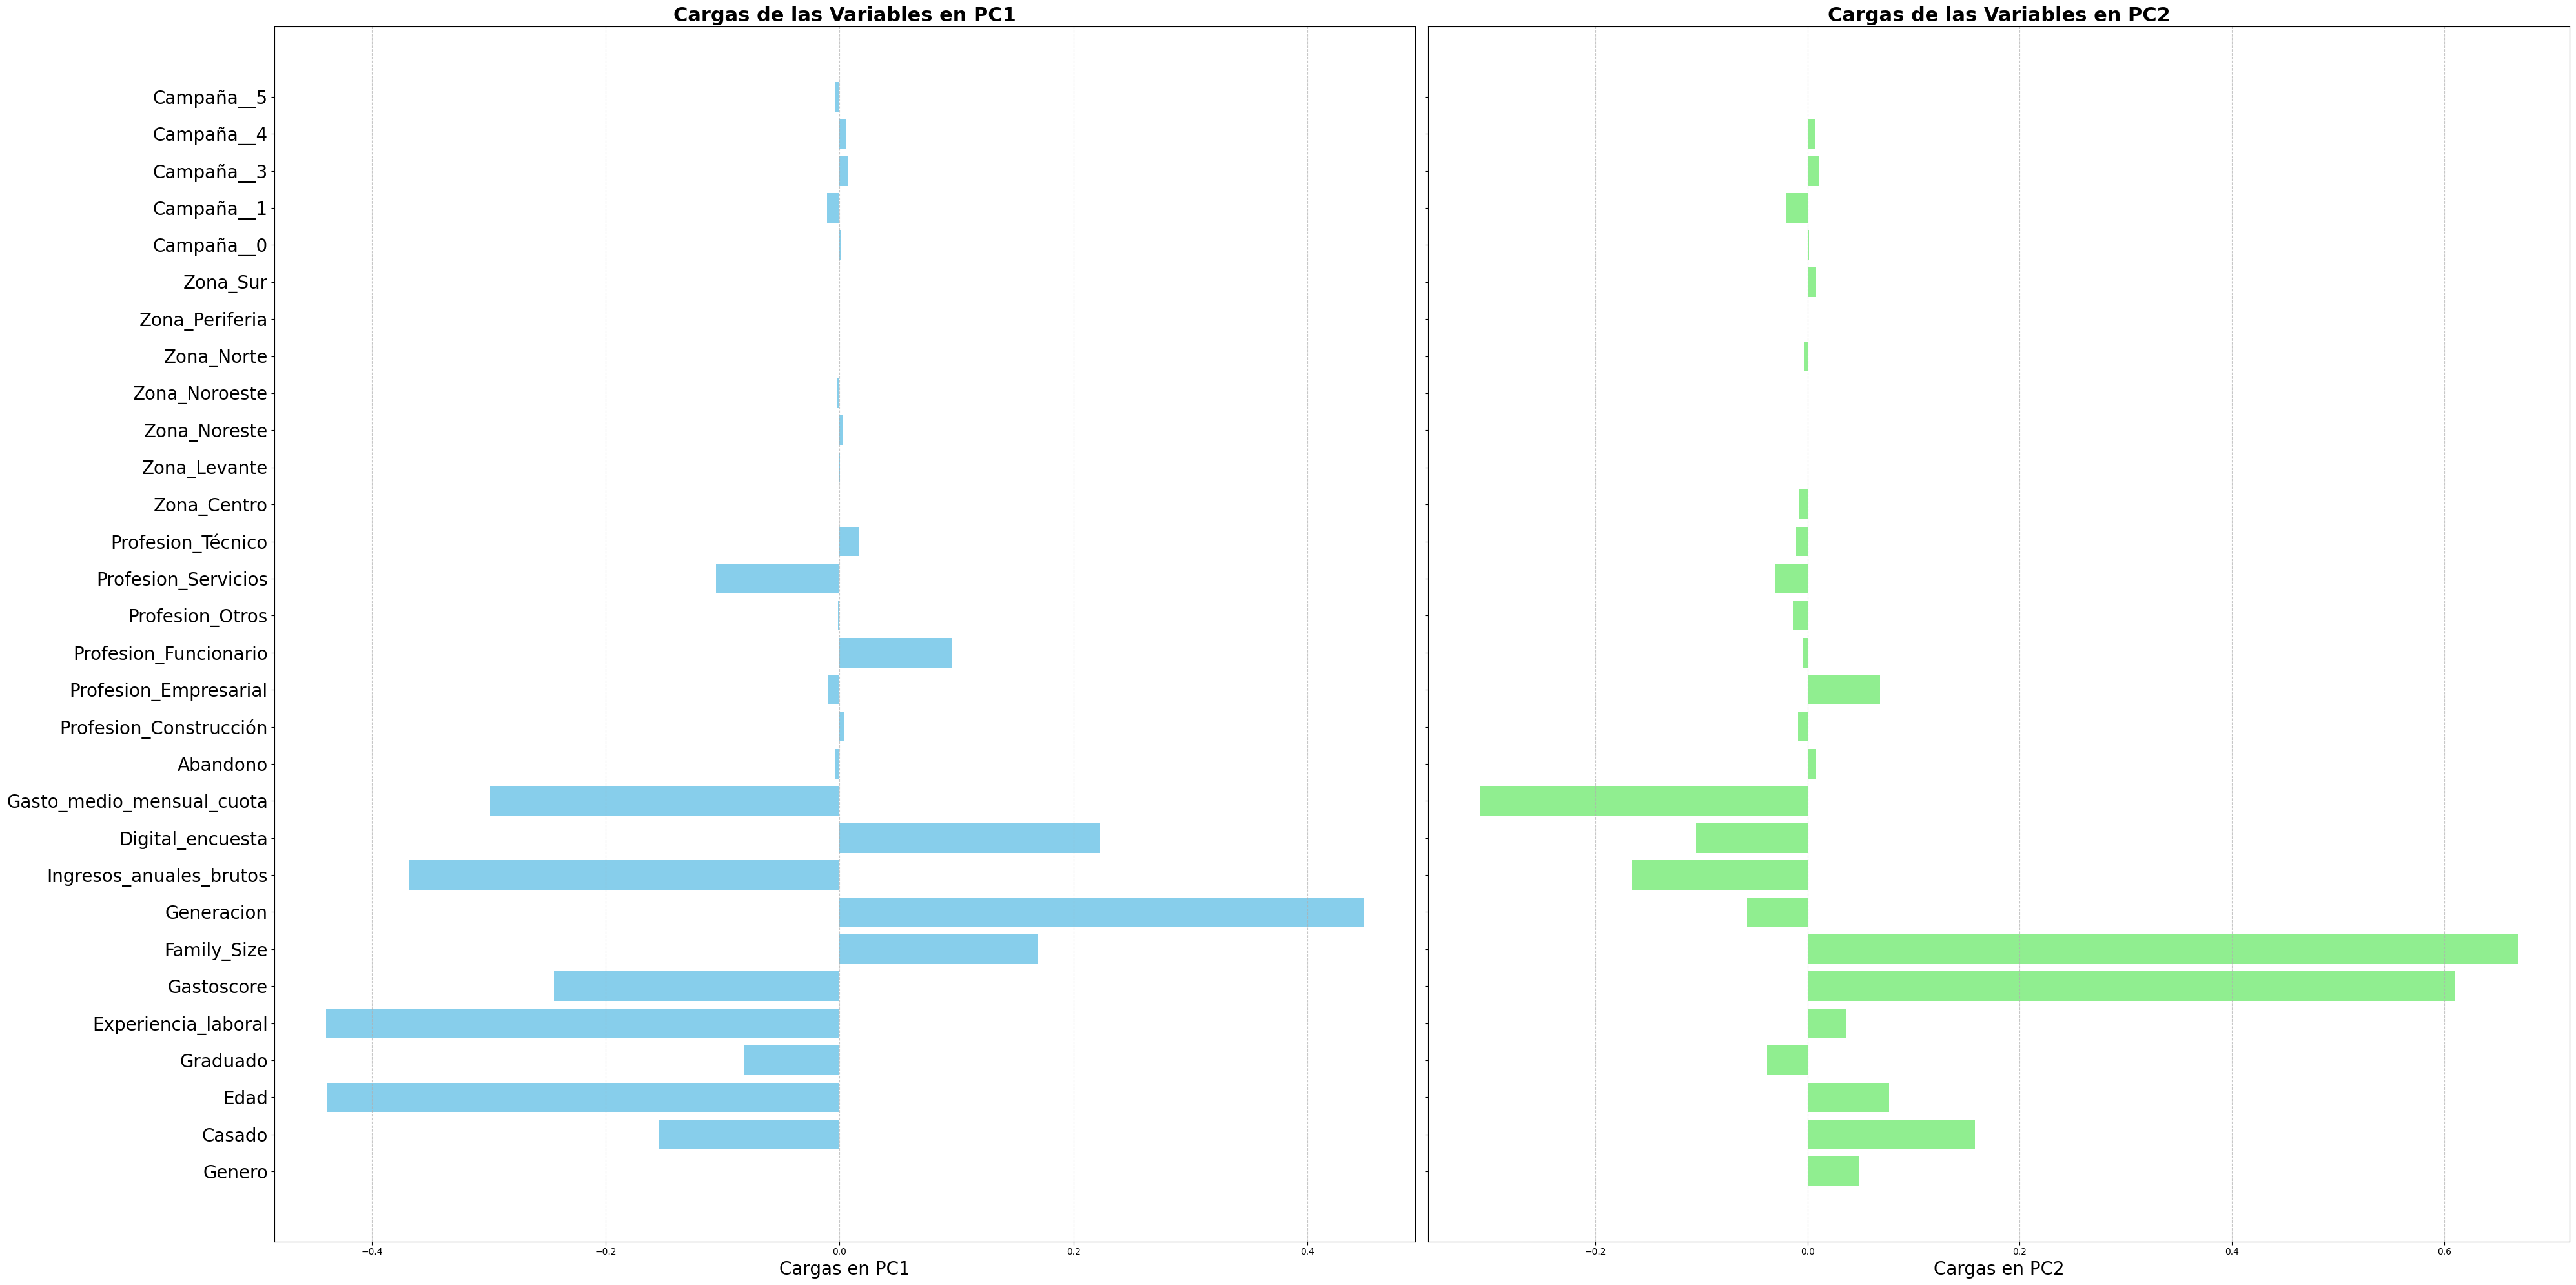

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 20), sharey=True)

# Gráfico de Cargas para PC1.
axes[0].barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
axes[0].set_xlabel('Cargas en PC1', fontsize=20)
axes[0].set_title('Cargas de las Variables en PC1', fontsize=22, fontweight='bold')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.7)

# Gráfico de Cargas para PC2.
axes[1].barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
axes[1].set_xlabel('Cargas en PC2', fontsize=20)
axes[1].set_title('Cargas de las Variables en PC2', fontsize=22, fontweight='bold')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)

# Visualización de las etiquetas del eje Y.
for ax in axes:
    ax.tick_params(
        axis='y',
        labelsize=20,
        colors='black',
        labelrotation=0
    )

plt.tight_layout()
plt.show()

**Análisis de cargas PCA: interpretación variable por variable (30 variables)**

**Variables sociodemográficas y comportamiento individual.**

1. **`Edad`**: Carga fuertemente negativa en **PC1**. Es una de las variables que más peso tiene en este componente, y sugiere que los clientes **más mayores se ubican en el extremo negativo**, mientras que los más jóvenes se agrupan en el extremo opuesto. Clientes mayores se agrupan en el extremo negativo. Propenso a: fidelidad, baja digitalización, consumo tradicional.

2. **`Experiencia Laboral`**: Muy alineada con **`Edad`**, también con **carga negativa alta en PC1**. Refleja la **trayectoria vital del cliente**, reforzando el perfil socioeconómico del eje. Propenso a: valorar la estabilidad, bajo churn, menor respuesta a campañas digitales.

3. **`Ingresos Anuales Brutos`**: Contribuye negativamente a **PC1**, en línea con edad y experiencia. Aporta al eje de **nivel adquisitivo y madurez profesional**. Propenso a: consumir productos premium, mayor CLTV.

4. **`Gasto Medio Mensual Cuota`**: También con carga negativa en PC1 y PC2, lo que la vincula al **perfil de gasto**, pero desde una perspectiva económica general. Propenso a: permanencia si el valor percibido es alto, sensible a calidad de servicio.

5. **`Gasto Score`**: Tiene carga **negativa en PC1** pero **muy positiva en PC2**. Esto indica que el nivel de gasto también se vincula a **comportamiento de consumo**, no solo a nivel adquisitivo. Propenso a: ser objetivo ideal para cross-selling o retención con beneficios.

6. **`Family Size`**: La variable con **mayor carga positiva en PC2**. Es clave en la diferenciación basada en **estructura familiar**, y un fuerte componente de segmentación en comportamiento. Propenso a: buscar planes familiares, paquetes combinados, mayor valor por cliente.

7. **`Digital Encuesta`**: Carga **positiva en PC1**. Esta variable marca a los **clientes más digitalizados**, quienes tienden a ser más jóvenes, con menor experiencia laboral, pero mayor afinidad a canales modernos. Propenso a: aceptar ofertas digitales, autorresolución, campañas por canales online.

8. **`Generación`**: Carga fuertemente **positiva en PC1**, lo que confirma su comportamiento opuesto al de `Edad`. Ayuda a identificar generaciones jóvenes que se agrupan en el extremo opuesto del eje tradicional. Propenso a: respuestas rápidas a estímulos digitales, menos fidelidad, más sensibilidad a experiencias.

9. **`Graduado`**: Con carga baja y negativa en PC1. No tiene un peso importante en la segmentación, pero podría estar ligeramente asociada a clientes tradicionales o con mayor edad.

10. **`Genero`**: Carga muy baja. **No contribuye de forma significativa** a ninguno de los dos componentes, por lo que no es determinante en la segmentación. Carga despreciable. Sin distinción clara por sexo. Propenso a: ningún comportamiento específico. No aporta valor predictivo.

11. **`Casado`**: Carga **positiva moderada en PC2**, aportando al eje de estructura familiar. Puede estar vinculado con decisiones de gasto o hábitos más estables. Propenso a: estabilidad, planes familiares, mayor gasto mensual estructurado.

12. **`Abandono`**: Carga **casi nula**, lo que indica que el abandono no está relacionado directamente con las variables que definen PC1 y PC2.

**Variables profesionales.**

13. **`Profesion: Técnico`**: Carga positiva muy baja. Tiene escaso impacto en el modelo, aunque podría estar asociado a perfiles más estructurados. Propenso a: valor por detalle técnico, fidelización si se le comunica con rigor.

14. **`Profesion: Funcionario`**: Carga ligera positiva en PC1. Está cerca del perfil estable y tradicional. Propenso a: estabilidad, bajo churn, interés por seguridad y confianza en la marca.

15. **`Profesion: Construcción`**, **`Profesion: Empresarial`**, **`Profesion: Otros`**, **`Profesion: Servicios`**: Todas con **cargas muy pequeñas**, lo que indica que **el tipo de profesión no es un gran diferenciador en PC1 ni PC2**. Servicios y otros tienen cargas levemente negativas, lo que puede indicar asociación con perfiles menos estructurados. Propenso a: no tienen un patrón claro común. Puede ser útil en combinación con otras variables.

**Zonas geográficas.**

17. **`Zona: Centro`**, **`Zona: Levante`**, **`Zona: Noreste`**, **`Zona: Noroeste`**, **`Zona: Norte`**, **`Zona: Periferia`**, **`Zona: Sur`**: Todas estas variables tienen **cargas mínimas (cercanas a cero)**. Esto significa que **la localización geográfica no influye directamente en los ejes de segmentación definidos por PC1 y PC2**. Aun así, pueden ser útiles para enriquecer la interpretación posterior de los clusters. **Todas con cargas prácticamente nulas**. Cliente de cualquier zona. Propenso a: no se puede definir comportamiento solo con la zona. Aporta contexto, no segmentación directa.

**Campañas.**

18. **`Campaña 0`, `Campaña 1`, `Campaña 3`, `Campaña 4`, `Campaña 5`**:
      - **`Campaña 1`** tiene la **carga negativa más alta** de las campañas en ambos componentes, lo que puede indicar un perfil diferenciado.
      - **`Campaña 3` y `Campaña 4`** tienen **cargas positivas leves en PC2**, asociadas a comportamiento activo o consumo.
      - **`Campaña 0`y `Campaña 5`**  están muy cerca del centro: fueron probablemente campañas más generalistas.


**Conclusión general.**
- **PC1** se estructura claramente en torno a un **eje socioeconómico**, donde destacan **`Edad`, `Experiencia laboral`, `Ingresos`** y **`Gasto Medio Mensual`**.
- **PC2** recoge la dimensión **familiar y de comportamiento**, destacando **`Family_Size`, `Casado`** y **`Gasto Score`**.
- Las demás variables (profesión, género, zona, campañas) **aportan menos al modelo**, pero pueden ser útiles al interpretar los clusters finales.

**Significado de los componentes principales.**
- **PC1 – Perfil Socioeconómico Tradicional vs. Digital Joven:** Agrupa edad, experiencia, ingresos (lado negativo) frente a generación y digitalización (lado positivo). Diferencia claramente **clientes tradicionales y consolidados** frente a **jóvenes digitales**.

- **PC2 – Comportamiento Familiar y Consumo:** Diferencia clientes según su **tamaño familiar**, **estado civil** y **nivel de gasto relativo**, formando un eje relacionado con la estructura de hogar y comportamiento de compra.

In [234]:
# Umbral de significancia para las cargas.
umbral = 0.1

variables_a_eliminar_df = cargas_df[
    (cargas_df['PC1'].abs() < umbral) & (cargas_df['PC2'].abs() < umbral)
].copy()

# Orden por carga absoluta total.
variables_a_eliminar_df['abs_total'] = variables_a_eliminar_df['PC1'].abs() + variables_a_eliminar_df['PC2'].abs()
variables_a_eliminar_df = variables_a_eliminar_df.sort_values(by='abs_total')

print("Variables candidatas a eliminar por baja carga en PC1 y PC2:")
variables_a_eliminar_df[['PC1', 'PC2']]

Variables candidatas a eliminar por baja carga en PC1 y PC2:


PC1       PC2
Zona_Levante            0.000217 -0.000048
Zona_Periferia         -0.000292  0.000991
Zona_Noroeste          -0.001705  0.000319
Zona_Norte             -0.000139 -0.002640
Campaña__0              0.001648  0.001557
Zona_Noreste            0.002379  0.000906
Campaña__5             -0.003400  0.000886
Zona_Centro            -0.000051 -0.007732
Zona_Sur               -0.000409  0.008204
Campaña__4              0.005101  0.006698
Abandono               -0.004042  0.007879
Profesion_Construcción  0.003546 -0.008956
Profesion_Otros        -0.001393 -0.013726
Campaña__3              0.007395  0.011039
Profesion_Técnico       0.016636 -0.010703
Campaña__1             -0.010744 -0.020181
Genero                 -0.000922  0.049073
Profesion_Empresarial  -0.009553  0.068572
Profesion_Funcionario   0.096486 -0.004570
Graduado               -0.081598 -0.038239

Con el objetivo de construir un modelo de segmentación más eficiente y explicativo, se ha realizado un proceso de **selección de variables** basado en su **contribución estadística a los componentes principales** generados por el Análisis de Componentes Principales (PCA).

Este análisis ha evidenciado que algunas variables presentan **cargas muy próximas a cero en ambos ejes principales (PC1 y PC2)**. Esto implica que **no aportan información significativa a la varianza explicada por el modelo**, y por tanto **no contribuyen de manera relevante a la diferenciación entre clientes** en este espacio reducido. En consecuencia, dichas variables han sido **eliminadas únicamente del proceso de construcción del PCA**, con el fin de:

- **Reducir el ruido** del modelo y eliminar redundancias estadísticas.
- **Aumentar la varianza explicada acumulada**, favoreciendo la compresión de la información en menos dimensiones.
- **Mejorar la interpretabilidad** de los componentes, facilitando un análisis más claro y segmentaciones más efectivas.

No obstante, es importante destacar que estas variables **no han sido descartadas del análisis general**, sino que serán utilizadas en fases posteriores, especialmente **en la caracterización y descripción cualitativa de los clusters obtenidos mediante el modelo de clustering (K-Means)**.

Este enfoque permite aprovechar lo mejor de ambos mundos:
- Por un lado, un modelo PCA más compacto, robusto y estadísticamente optimizado.
- Por otro, una segmentación enriquecida con variables contextuales (como profesión, zona geográfica o campañas) que, aunque no fueron clave para la construcción del espacio PCA, **sí aportan valor estratégico para interpretar los perfiles resultantes** y orientar la toma de decisiones de negocio.

In [235]:
# Variables con cargas bajas en PC1 y PC2. Se consideran redundantes, ya que no aportan información significativa a las componentes principales.
# La exclusión de estas variables puede simplificar el modelo y mejorar la interpretabilidad subiendo la varianza explicada.
redundantes = variables_a_eliminar_df.index.tolist()

### **PCA optimizado: Variables seleccionadas tras análisis de cargas.**
Tras la aplicación inicial del Análisis de Componentes Principales (PCA) sobre el conjunto completo de variables transformadas, se realizó un análisis detallado de las cargas de cada variable sobre los dos primeros componentes principales. Este análisis permitió identificar aquellas variables que presentaban **cargas muy bajas en ambos ejes**, lo que indica una **baja capacidad para contribuir a la varianza explicada del modelo**.

Como resultado, se procedió a **eliminar dichas variables del conjunto de entrada del PCA**, conservando únicamente aquellas que demostraron tener un **mayor poder discriminativo y una contribución significativa** a la estructura del espacio multidimensional. Esta depuración busca **mejorar la eficiencia del modelo**, **aumentar la varianza explicada por los componentes principales**, y al mismo tiempo **garantizar una mejor interpretabilidad** de los ejes generados.

El nuevo PCA, construido a partir de este subconjunto optimizado de variables, constituye la **base definitiva para la segmentación posterior mediante K-Means**. Esta versión refinada del modelo nos permite generar clusters más representativos y estables, alineados con dimensiones clave del perfil del cliente como la edad, los ingresos, el tamaño del hogar, el comportamiento de gasto y el nivel de digitalización.

In [236]:
df.shape

(10065, 30)

In [237]:
# Se recomienda no incluir variables con poca carga en PC1 y PC2. Detectadas en el PCA anterior.
df.drop(columns=redundantes, inplace=True)
for i in redundantes:
    if i in continuous_cols:
        continuous_cols.remove(i)
    else:
        binary_cols.remove(i)
print(f"Variables eliminadas: {redundantes}")

Variables eliminadas: ['Zona_Levante', 'Zona_Periferia', 'Zona_Noroeste', 'Zona_Norte', 'Campaña__0', 'Zona_Noreste', 'Campaña__5', 'Zona_Centro', 'Zona_Sur', 'Campaña__4', 'Abandono', 'Profesion_Construcción', 'Profesion_Otros', 'Campaña__3', 'Profesion_Técnico', 'Campaña__1', 'Genero', 'Profesion_Empresarial', 'Profesion_Funcionario', 'Graduado']


In [238]:
print(f"Variables continuas seleccionadas para PCA: {continuous_cols}")
print(f"Variables binarias detectadas: {binary_cols}")

Variables continuas seleccionadas para PCA: ['Edad', 'Experiencia_laboral', 'Gastoscore', 'Family_Size', 'Generacion', 'Ingresos_anuales_brutos', 'Digital_encuesta', 'Gasto_medio_mensual_cuota']
Variables binarias detectadas: ['Casado', 'Profesion_Servicios']


In [239]:
df.head()

Casado      Edad  Experiencia_laboral  Gastoscore  Family_Size  \
ID                                                                         
CLI10          1  1.033109             0.774266   -0.725243     0.170843   
CLI100         1  0.869618             0.774266    0.634588    -0.477793   
CLI1000        1  0.924115             0.774266    0.634588     0.170843   
CLI10000       0 -0.819788            -0.486939   -0.725243     0.819479   
CLI10001       1  0.215654             0.774266    0.634588    -0.477793   

          Generacion  Ingresos_anuales_brutos  Digital_encuesta  \
ID                                                                
CLI10      -0.629473                 1.095408          0.225548   
CLI100     -0.629473                 1.277962         -0.310242   
CLI1000    -0.629473                -0.538872          0.759729   
CLI10000    0.676307                -0.888873          0.581132   
CLI10001   -0.629473                -0.738436          0.162798   

          Gasto_medio_mensual_cuota  Profesion_Servicios  
ID                                                        
CLI10                      1.673825                    0  
CLI100                     0.312961                    0  
CLI1000                   -0.594283                    1  
CLI10000                  -0.594283                    0  
CLI10001                  -0.594283                    0

#### **Entrenamiento del modelo PCA: 2 Componentes.**
Se seleccionan los dos primeros autovectores (componentes principales) de la matriz de covarianza de los datos escalados, que mayor proporción de varinaza explican.

In [240]:
# Aplicación PCA.
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df)

# Crear DataFrame con los componentes principales.
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

#### **Varianza explicada.**
Calculamos la proporción de varianza explicada por cada componente principal. Esto nos indica cuánta información (variabilidad) de los datos originales se conserva en cada componente.

In [241]:
# Obtención de la varianza explicada.
varianza_explicada = pca.explained_variance_ratio_

# Mostrar varianza explicada.
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}% de la varianza explicada")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 47.59% de la varianza explicada
PC2: 13.86% de la varianza explicada
Varianza total explicada: 61.45%


#### **Biplot de clientes y vectores de variables.**
Como parte del proceso de segmentación, se aplicó un análisis de componentes principales (PCA) con el fin de reducir la complejidad del conjunto de datos y facilitar su visualización.

El resultado se visualiza a través de un **biplot**, un gráfico que no solo muestra cómo se distribuyen los datos en las dos primeras dimensiones principales, sino que también ilustra de forma clara la **influencia que tiene cada variable original sobre estas dimensiones**. Esta herramienta resulta clave para interpretar el peso relativo de cada característica y su utilidad en la diferenciación de perfiles de clientes.

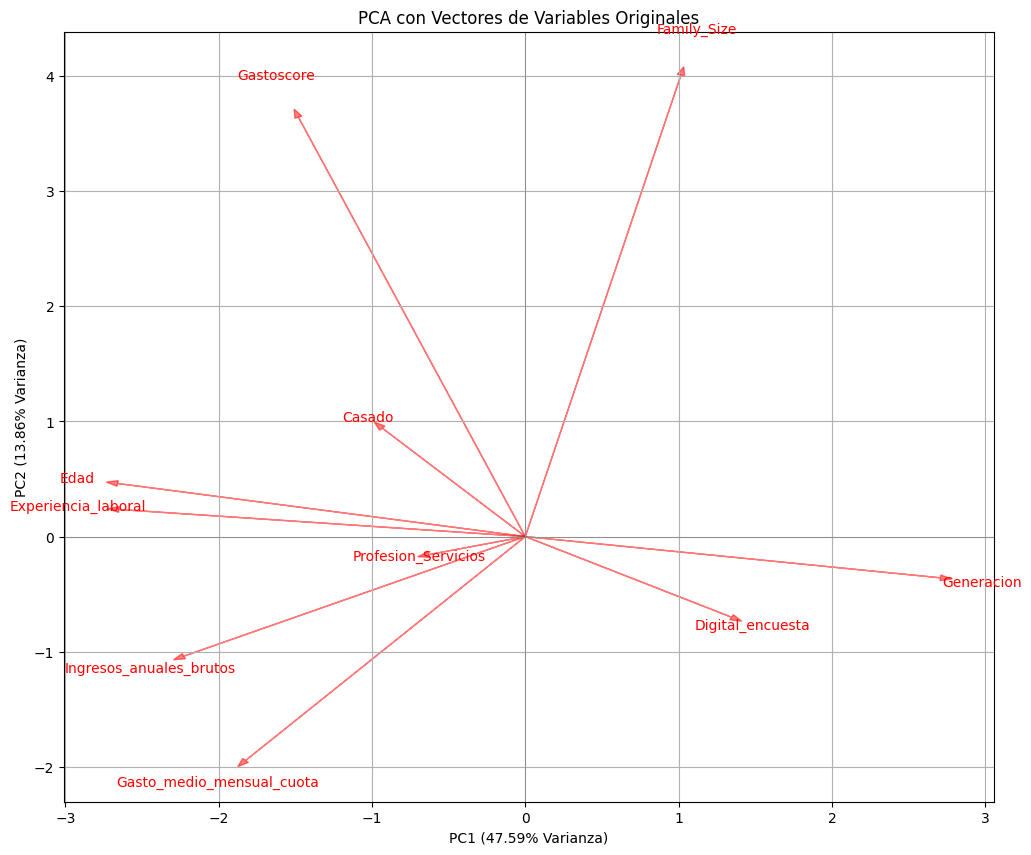

In [242]:
# Visualización: Biplot.
cargas = pca.components_.T
escalamiento = 6
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12, 10))
for i, var in enumerate(df.columns):
    plt.arrow(0, 0, cargas_scaled[i, 0], cargas_scaled[i, 1],
            color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i, 0]*1.1, cargas_scaled[i, 1]*1.1,
            var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

#### **Análisis de cargas.**
Tras identificar visualmente la distribución de las variables mediante el biplot, es fundamental profundizar en el análisis de cargas para entender con precisión **cómo y cuánto contribuye cada variable a los componentes principales del modelo PCA**.

Este análisis numérico permite cuantificar la influencia de cada variable dentro de las nuevas dimensiones creadas por el PCA. Las **cargas** (o “loadings”) representan el **peso que tiene cada variable original en la construcción de un componente**, y son clave para interpretar el sentido de estos ejes.

In [243]:
# DataFrame de Cargas.
cargas_df = pd.DataFrame(cargas, index=df.columns, columns=['PC1', 'PC2'])
print("Cargas de las variables en las componentes principales:")
cargas_df

Cargas de las variables en las componentes principales:


PC1       PC2
Casado                    -0.155385  0.156929
Edad                      -0.443042  0.076854
Experiencia_laboral       -0.441745  0.039213
Gastoscore                -0.246562  0.607148
Family_Size                0.169219  0.668131
Generacion                 0.451262 -0.059726
Ingresos_anuales_brutos   -0.371090 -0.173153
Digital_encuesta           0.224187 -0.116726
Gasto_medio_mensual_cuota -0.303977 -0.324103
Profesion_Servicios       -0.104855 -0.026143

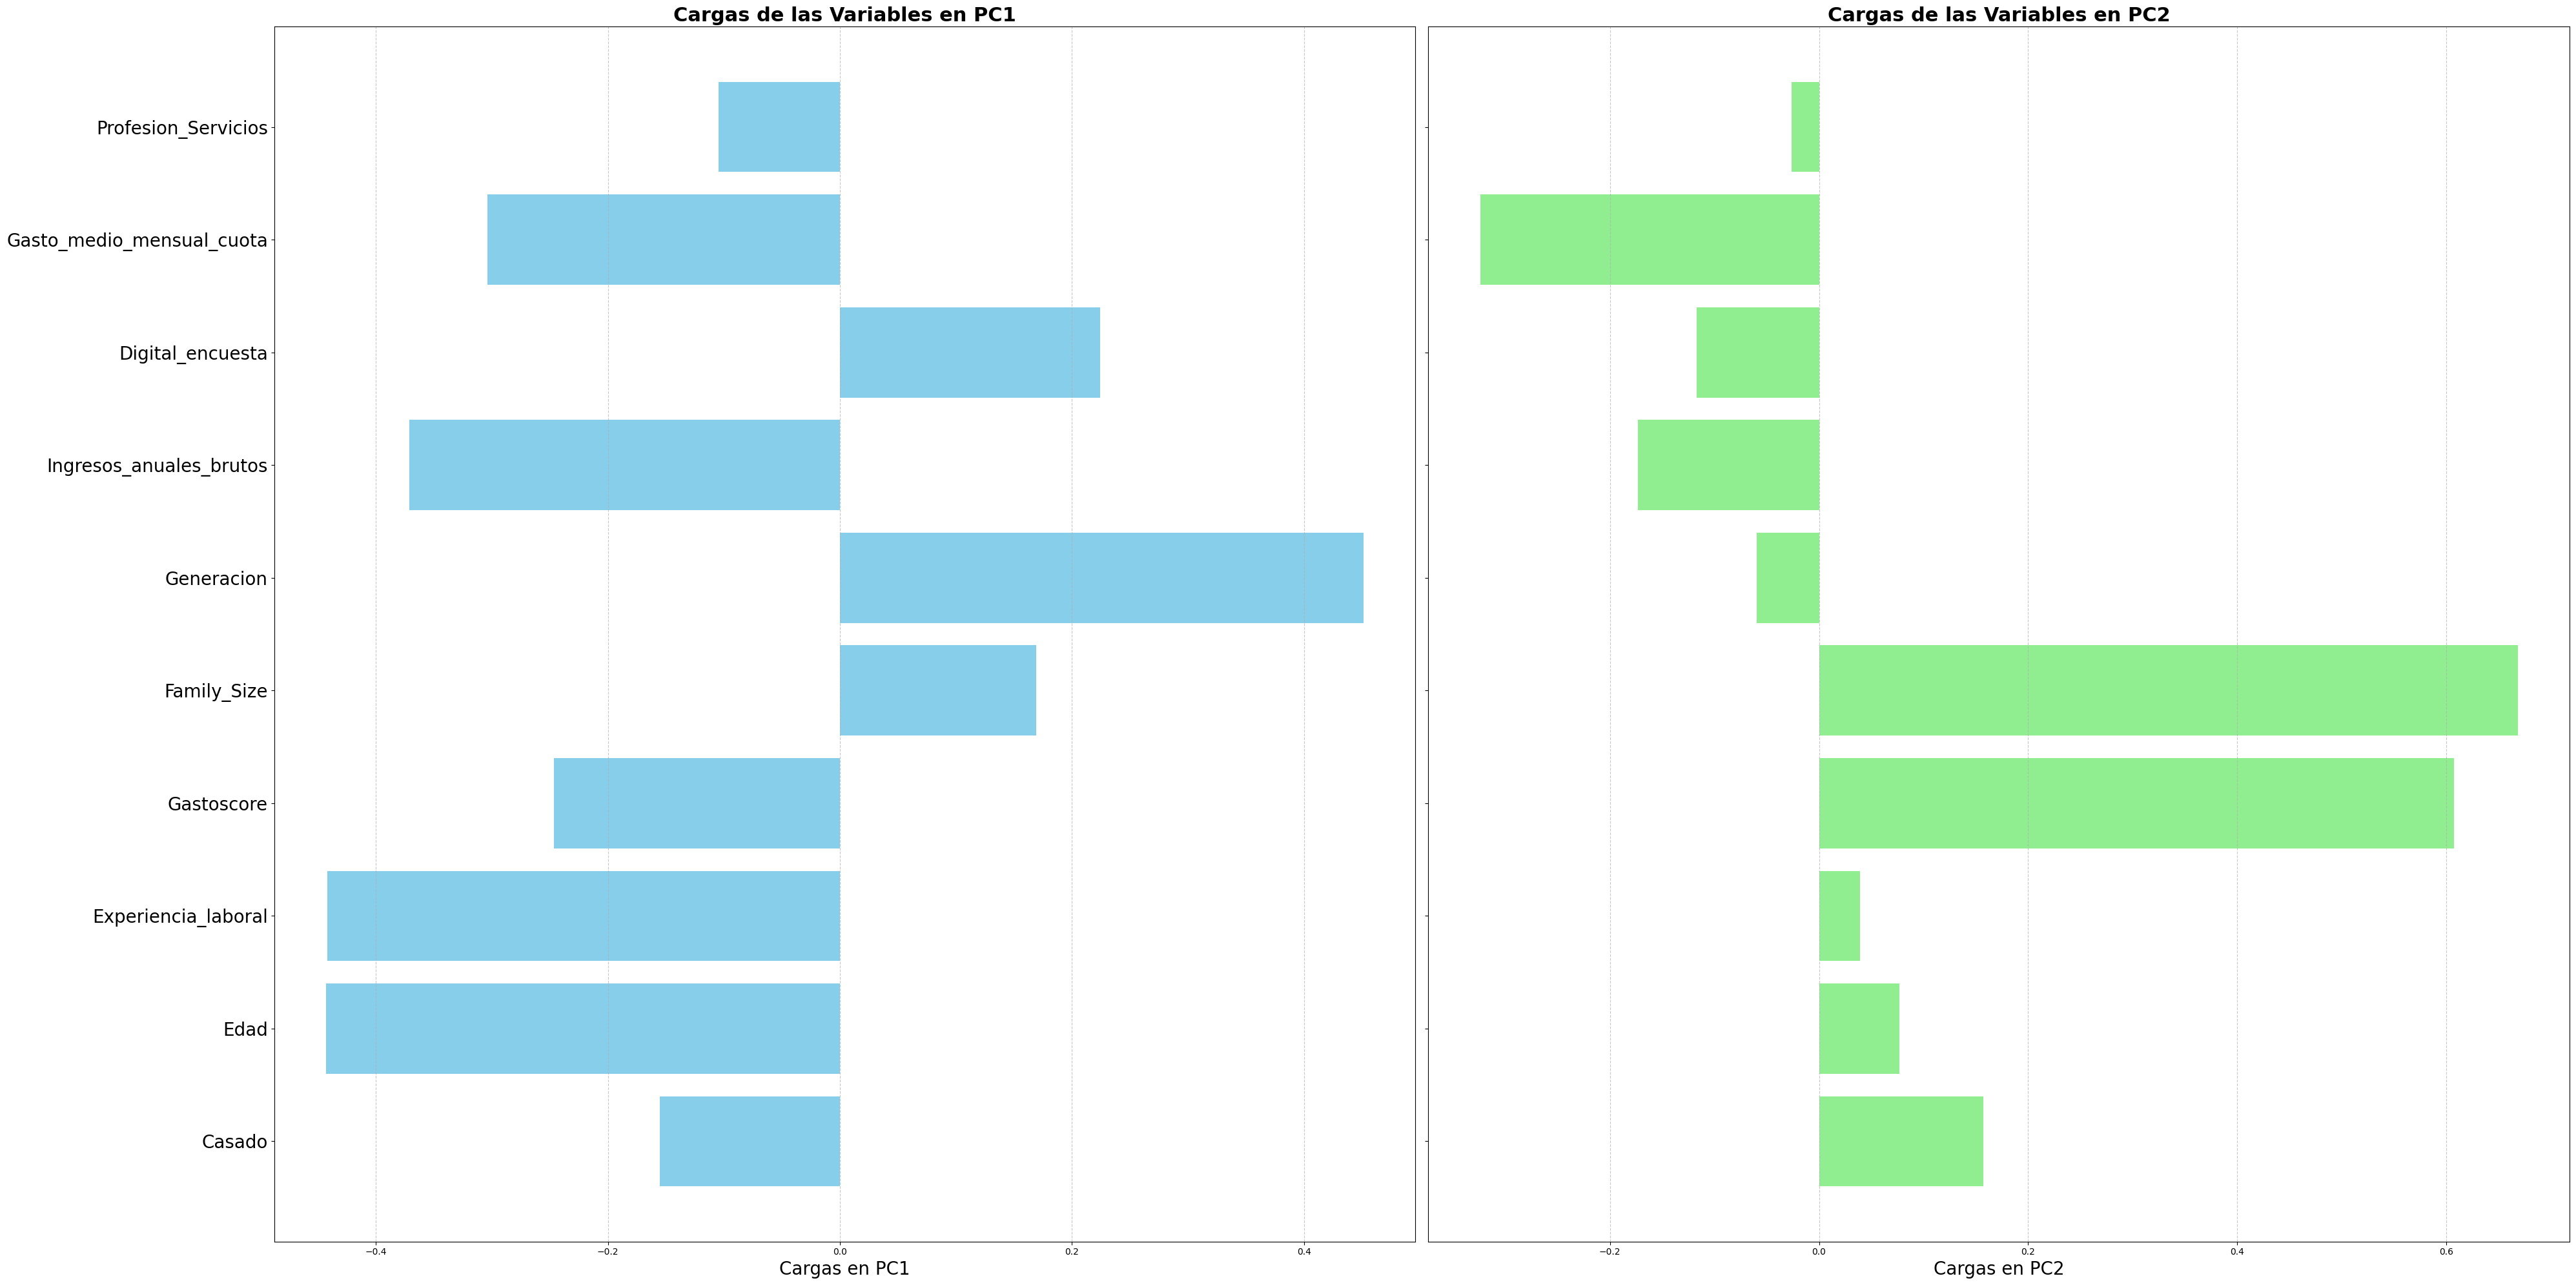

In [244]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 20), sharey=True)

# Gráfico de Cargas para PC1.
axes[0].barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
axes[0].set_xlabel('Cargas en PC1', fontsize=20)
axes[0].set_title('Cargas de las Variables en PC1', fontsize=22, fontweight='bold')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.7)

# Gráfico de Cargas para PC2.
axes[1].barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
axes[1].set_xlabel('Cargas en PC2', fontsize=20)
axes[1].set_title('Cargas de las Variables en PC2', fontsize=22, fontweight='bold')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)

# Visualización de las etiquetas del eje Y.
for ax in axes:
    ax.tick_params(
        axis='y',
        labelsize=20,
        colors='black',
        labelrotation=0
    )

plt.tight_layout()
plt.show()

#### **Determinación óptima del número de clusters: Elbow Method.**
Una vez reducido el conjunto de variables mediante el Análisis de Componentes Principales (PCA), el siguiente paso consiste en **determinar el número óptimo de clusters para la segmentación de clientes**. Para ello, se aplica el Método del Codo (Elbow Method), que permite identificar el punto en el que añadir más clusters no mejora significativamente la compactación de los grupos.

El criterio se basa en analizar la inercia intra-cluster (suma de distancias de cada punto al centroide de su cluster) y localizar el punto de inflexión o "codo" en la curva.

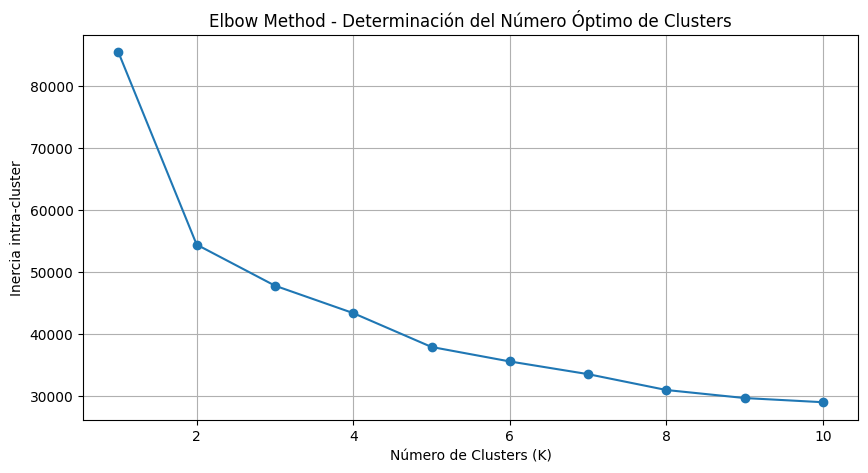

In [245]:
# Evaluación de la inercia para distintos valores de K.
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo.
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Determinación del Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia intra-cluster')
plt.grid()
plt.show()

In [246]:
clusters = 5 # Número óptimo de clusters determinado visualmente.
print(f"El número óptimo de clusters es: {clusters}")

El número óptimo de clusters es: 5


#### **Segmentación de clientes mediante K-Means.**
Una vez determinado el número óptimo de clusters mediante el Elbow Method, el siguiente paso consiste en aplicar el algoritmo K-Means para segmentar a los clientes en función de los componentes principales obtenidos con el PCA.

El objetivo de este proceso es **identificar grupos homogéneos de clientes que compartan características similares**, facilitando la elaboración de estrategias personalizadas de fidelización y maximización del valor del cliente.

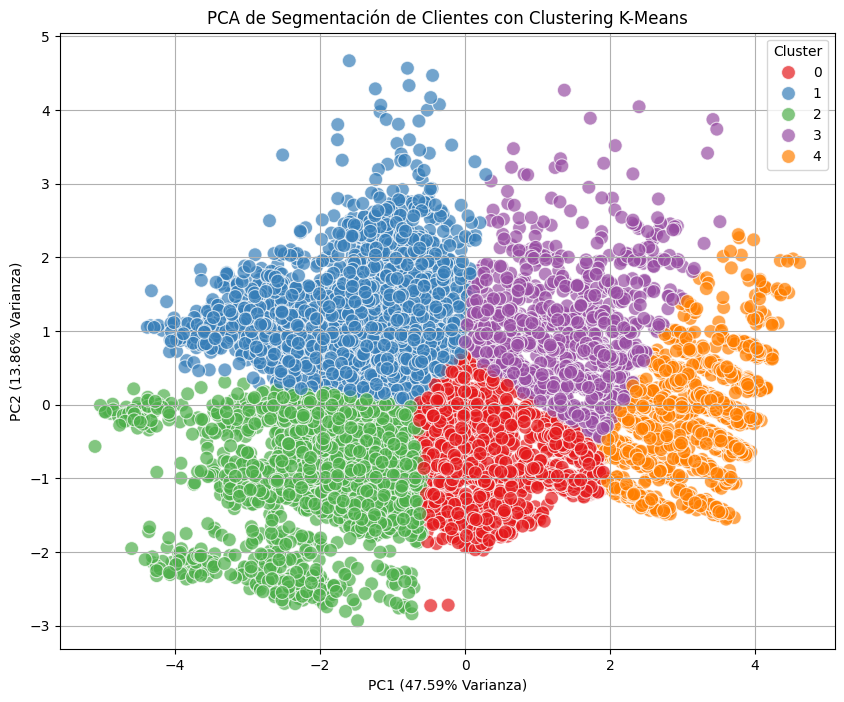

In [247]:
# Clustering con K-Means sobre PCA.
kmeans = KMeans(n_clusters=clusters, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame.
pca_df['Cluster'] = clusters

# Visualizar PCA con Clusters.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA de Segmentación de Clientes con Clustering K-Means')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

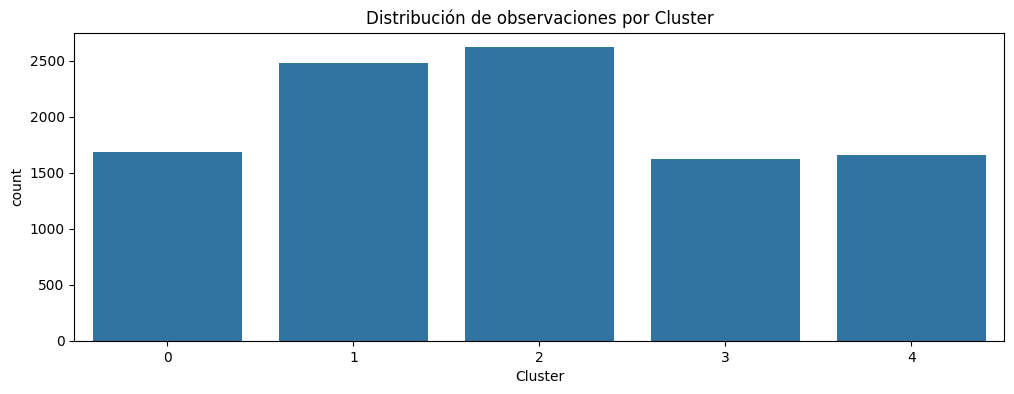

In [248]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Cluster', data=pca_df)
plt.title('Distribución de observaciones por Cluster')
plt.show()

Tras depurar el conjunto de variables utilizadas en el análisis PCA mediante un criterio basado en cargas factoriales, se procedió a reconstruir el espacio dimensional únicamente con las variables que aportaban valor significativo a los componentes principales. Este proceso permitió aumentar la varianza explicada acumulada y generar un modelo más robusto y fácilmente interpretable.

El clustering aplicado sobre los dos primeros componentes (PC1 y PC2) del nuevo PCA reveló una segmentación clara y bien estructurada. Los grupos obtenidos presentan **fronteras definidas** y una **distribución relativamente equilibrada de clientes**. Visualmente, el gráfico muestra una disposición ordenada en el plano PCA, lo que indica que los ejes están captando diferencias sustanciales entre perfiles.

Por tanto, el modelo PCA-KMeans final puede considerarse una solución técnicamente sólida para segmentar a los clientes según variables clave como edad, ingresos, experiencia laboral, digitalización o comportamiento de gasto. Esta segmentación será utilizada como base para la caracterización posterior y la definición de perfiles estratégicos.

## **Reducción de dimensionalidad mediante t-SNE.**
A pesar de los buenos resultados obtenidos mediante el modelo PCA optimizado, es importante considerar que esta técnica se basa en la proyección lineal de los datos, y por tanto, **podría no capturar relaciones no lineales o patrones complejos presentes en el dataset**.

Con el fin de validar la estructura latente de los datos y explorar posibles agrupaciones que no hayan sido detectadas por el PCA, se decidió aplicar la técnica **t-distributed Stochastic Neighbor Embedding (t-SNE)**. A diferencia del PCA, t-SNE no busca explicar varianza, sino preservar las relaciones de vecindad entre puntos en un espacio de menor dimensión, lo que lo convierte en una herramienta ideal para **identificar agrupamientos naturales incluso cuando estos no son linealmente separables**.

El objetivo de esta fase es comparar la estructura visual obtenida mediante t-SNE con la generada por PCA y evaluar si existen patrones de agrupamiento alternativos que puedan enriquecer o complementar la segmentación previa. Esta exploración no sustituye al modelo PCA, sino que lo acompaña desde una perspectiva visual y no lineal.

#### **Entrenamiento del modelo t-SNE: 2 Componentes.**
Con el conjunto de variables depuradas y escaladas, se procede a entrenar el modelo t-SNE con el objetivo de proyectar los datos en un espacio bidimensional. Esta representación permite **preservar la estructura local de los datos**, es decir, mantener la proximidad relativa entre observaciones similares.

A diferencia del PCA, t-SNE **no busca maximizar la varianza explicada**, sino **conservar las relaciones de vecindad**. Por tanto, los dos componentes generados no son interpretables como ejes tradicionales, pero son muy útiles para **visualizar agrupaciones latentes** en los datos.

In [249]:
# TSNE: Reducción de Dimensionalidad No Lineal.
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Aplicar t-SNE a los datos BORRADAS las variables redundantes, ya que no aportan información significativa.
## Aunque t-SNE no usa las cargas directamente, sí se ve muy afectado por el ruido.
## Las variables que ya detectadas como irrelevantes (porque tenían cargas bajas) probablemente: No ayudan a separar grupos;  Solo hacen que el t-SNE sea más lento o confuso; Aportan poco o nada.
tsne_components = tsne.fit_transform(df)
tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])

# Obtener todos los puntos del t-SNE.
tsne_points = tsne_df.values.tolist()

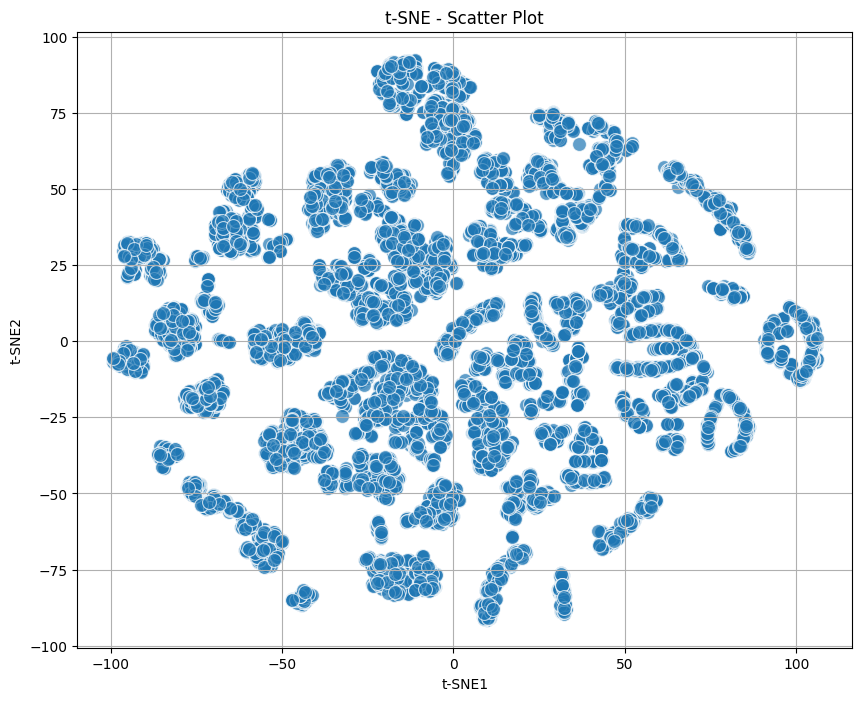

In [250]:
# Visualización: Scatter Plot.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', data=tsne_df, s=100, alpha=0.7)
plt.title('t-SNE - Scatter Plot')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.grid(True)
plt.show()

La visualización obtenida mediante t-SNE revela una **estructura compleja pero bien definida** en los datos. Se observan múltiples **agrupaciones densas y separadas entre sí**, lo cual indica que **existen patrones de comportamiento latente en el conjunto de clientes** que van más allá de lo que las técnicas lineales como el PCA podían captar.

En concreto:
- Los puntos se organizan en **formas curvas y no lineales**, característica típica de datos con relaciones complejas entre variables.
- Se aprecia la existencia de **grupos compactos**, así como “cadenas” de puntos alargadas, lo que sugiere posibles subsegmentos o transiciones entre perfiles.
- **Los huecos entre grupos son claros**, lo cual es señal positiva: **t-SNE está identificando regiones con clientes similares entre sí pero diferentes de otros**.

Esto confirma que el t-SNE ha sido una herramienta útil para **descubrir la estructura real del espacio de clientes**, y representa una base visual sólida para aplicar técnicas de clustering (como K-Means) en esta fase del análisis.

#### **Determinación óptima del número de clusters: Elbow Method.**
Antes de aplicar el algoritmo de clustering sobre el espacio reducido generado por t-SNE, es necesario determinar el número óptimo de clusters. Una de las técnicas más utilizadas para este fin es el **método del codo (Elbow Method)**.

Esta técnica se aplicará directamente sobre los componentes `t-SNE1` y `t-SNE2`, con el objetivo de identificar **la estructura más eficiente y natural** en el conjunto de datos proyectado.

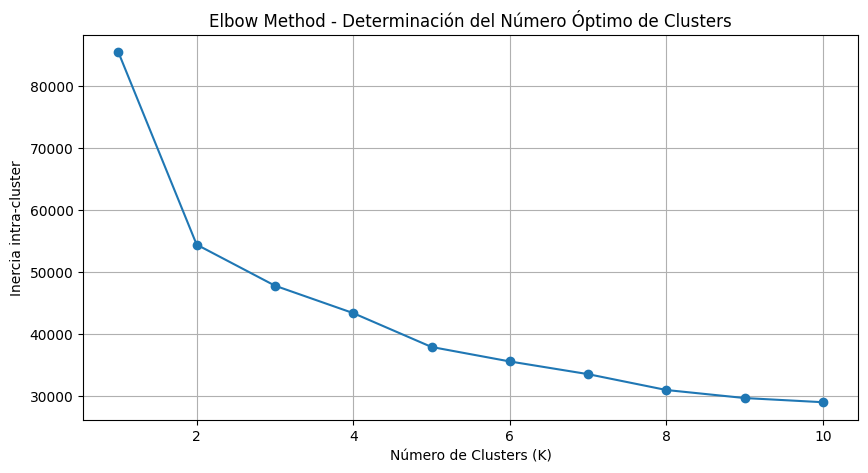

In [251]:
# Evaluación de la inercia para distintos valores de K.
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo.
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Determinación del Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia intra-cluster')
plt.grid()
plt.show()

In [252]:
clusters = 5 # Número óptimo de clusters determinado visualmente.
print(f"El número óptimo de clusters es: {clusters}")

El número óptimo de clusters es: 5


#### **Segmentación de clientes mediante K-Means.**
Una vez proyectados los datos en el espacio bidimensional generado por t-SNE y definido el número óptimo de clusters, se procede a aplicar el algoritmo de **K-Means** con el objetivo de segmentar a los clientes en grupos homogéneos.

El resultado de este proceso es una clasificación clara de cada cliente en un grupo específico, lo que permite avanzar hacia una **caracterización detallada de los perfiles identificados** y su posterior interpretación estratégica.

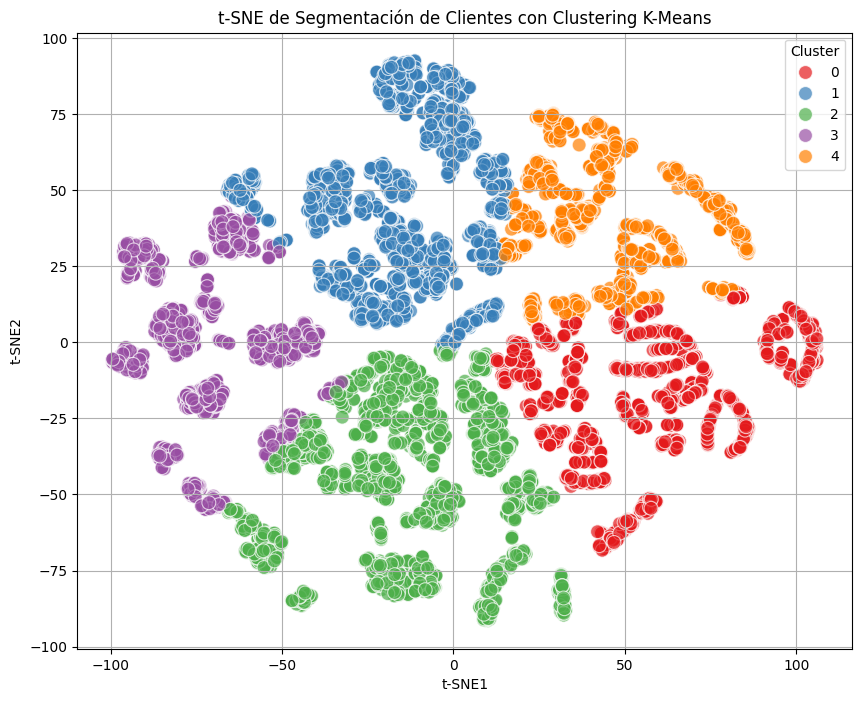

In [253]:
# Aplicar KMeans para clustering en t-SNE.
kmeans = KMeans(n_clusters=clusters, random_state=42)
clusters = kmeans.fit_predict(tsne_df[['t-SNE1', 't-SNE2']])

# Añadir clusters al DataFrame.
tsne_df['Cluster'] = clusters

# Visualización de Clusters.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='Set1', s=100, alpha=0.7)
plt.title('t-SNE de Segmentación de Clientes con Clustering K-Means')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.grid(True)
plt.show()

## **Exportación de resultados: Preparación para el Análisis de Negocio.**
Con la segmentación ya completada, el siguiente paso consiste en asociar cada cliente con su grupo correspondiente, tanto desde el modelo basado en PCA como desde la visualización t-SNE. Esto permitirá realizar un análisis cruzado más completo en el siguiente notebook desde una perspectiva de negocio.

Se añaden las etiquetas de cluster al dataset original. Guardamos el DataFrame completo con los clusters incorporados para su análisis posterior.

In [263]:
df_original['Cluster_PCA'] = pca_df['Cluster'].values
df_original['Cluster_tSNE'] = tsne_df['Cluster'].values

In [ ]:
df_original.head()

Genero  Casado  Edad  Graduado  Experiencia_laboral  Gastoscore  \
ID                                                                          
CLI10          0       1    67         1                    2           0   
CLI100         1       1    64         1                    2           1   
CLI1000        1       1    65         1                    2           1   
CLI10000       1       0    33         0                    1           0   
CLI10001       1       1    52         0                    2           1   
...          ...     ...   ...       ...                  ...         ...   
CLI9995        0       1    76         0                    2           2   
CLI9996        0       0    44         1                    2           0   
CLI9997        1       1    47         1                    2           2   
CLI9998        1       1    40         1                    1           2   
CLI9999        1       1    39         1                    1           1   

          Family_Size  Generacion  Ingresos_anuales_brutos  Digital_encuesta  \
ID                                                                             
CLI10               3           1                    93442              1385   
CLI100              2           1                    99774              1052   
CLI1000             3           1                    36756              1717   
CLI10000            4           2                    24616              1606   
CLI10001            2           1                    29834              1346   
...               ...         ...                      ...               ...   
CLI9995             2           1                    33389              1424   
CLI9996             1           1                    76067              1514   
CLI9997             3           1                    61300              1385   
CLI9998             3           2                   106015              1974   
CLI9999             2           2                    27169              1951   

          Gasto_medio_mensual_cuota  Abandono  Dias_cliente  \
ID                                                            
CLI10                            80         1           195   
CLI100                           50         1           360   
CLI1000                          30         0           407   
CLI10000                         30         0           544   
CLI10001                         30         1           170   
...                             ...       ...           ...   
CLI9995                          30         1           106   
CLI9996                          50         0           257   
CLI9997                          80         1           347   
CLI9998                          30         0           582   
CLI9999                          30         0           460   

          Profesion_Construcción  Profesion_Empresarial  \
ID                                                        
CLI10                          0                      0   
CLI100                         0                      0   
CLI1000                        0                      0   
CLI10000                       0                      0   
CLI10001                       0                      0   
...                          ...                    ...   
CLI9995                        0                      0   
CLI9996                        0                      0   
CLI9997                        0                      1   
CLI9998                        0                      0   
CLI9999                        0                      0   

          Profesion_Funcionario  Profesion_Otros  Profesion_Servicios  \
ID                                                                      
CLI10                         0                0                    0   
CLI100                        0                0                    0   
CLI1000                       0                0                    1   
CLI10000      

In [266]:
df_original.to_csv('../data/processed/IA_Client_Segment_sample_v2.csv', index=True)